In [19]:
source('libraries.R')
source('cdr3-QTL_functions.R')

### Uploading HLA data for cdr3_hla_matrices

In [14]:
hla_features <- read_tsv('../data/hla_features_wo_duplicates_healthy_and_ibd_those_with_cdr3.tsv')

Rows: 29962 Columns: 4
── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (3): patient_id, gene, allele
dbl (1): homo_hetero

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


### Preparing CDR3_HLA_matrices for HEALTHY and running the model

In [41]:
length_healthy_pairs <- c()
for (f in paste0('../HEALTHY/cdr3_hla_pairs/', list.files('../HEALTHY/cdr3_hla_pairs/'))){
    length_healthy_pairs <- c(length_healthy_pairs, nrow(fread(f)))
}

In [ ]:
cdr3_freq <- fread('../data/cdr3_freq_healthy_public_v2.tsv')
cdr3_freq_L_P <- split(cdr3_freq, by = c("length", "IMGT"))

dir_pair_path <- paste0('../HEALTHY/cdr3_hla_pairs/')
hla_gene = c('A', 'B', 'C', 'DPA1', 'DPB1', 'DQA1', 'DQB1','DRB1')
hla_matrices <- paste0('../hla_matrices_v3/wo_correlation/',list.files('../hla_matrices_v3/wo_correlation/'))

dir_results <- paste0('../HEALTHY/manova_results/')

manova_df_all <- fread('../manova_results_v3.tsv')[0,]
    
if (!file.exists(dir_pair_path)) {
dir.create(dir_pair_path, recursive = TRUE)
}
if (!file.exists(dir_results)) {
dir.create(dir_results, recursive = TRUE)
}


for (L_P_group in seq(1,length(cdr3_freq_L_P))){

    cdr3_L_P <- cdr3_freq_L_P[[L_P_group]]
    L <- unique(cdr3_L_P$length)
    P <- unique(cdr3_L_P$IMGT)
    
    cdr3_matrix <- cdr3_matrix_fun(cdr3_L_P)
    cdr3_matrix$L_P <- paste0(L,':',P)
    
    ind_in_cdr3 <- unique(cdr3_L_P$patient_id)

    for (f in hla_matrices){
        
        hla_matrix <- read_tsv(f) %>% filter(patient_id %in% ind_in_cdr3)
        pca_hla <- pca_hla_fun(hla_features %>% filter(patient_id %in% ind_in_cdr3))
        
        cdr3_hla_matrix <- hla_matrix %>%
            inner_join(cdr3_matrix, by='patient_id') %>% unite('pair', G_S,L_P, sep = ':') %>%
            inner_join(pca_hla, by = 'patient_id')
        name_pair <- cdr3_hla_matrix$pair[1]
        
        write_tsv(cdr3_hla_matrix, paste0(dir_pair_path,name_pair,'_matrix.tsv'))
        manova_results <- mlm_fun(cdr3_hla_matrix, dir_results)
        manova_df_all <- rbind(manova_df_all, manova_results)
        
    }
    }


fwrite(manova_df_all, '../HEALTHY/manova_results.tsv')



Rows: 1900 Columns: 3
── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): patient_id, G_S
dbl (1): allele_S

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message in data.frame(Omnibus, model = c("null", "full"), P_val, variance_explained):
“row names were found from a short variable and have been discarded”
Rows: 1900 Columns: 3
── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): patient_id, 

### MAIN MANOVA FOR BOTH WITH UNIQUE AND EXPANDED USING 3, 6 and 9 PCS

In [ ]:
hla_features <- read_tsv('../data/hla_features_wo_duplicates_healthy_and_ibd_those_with_cdr3.tsv')

pairs <- '../cdr3_hla_pairs_v3/'
pairs_paths <- paste0(pairs, list.files(pairs))

dir_pair_path <- paste0('../cdr3_hla_pairs_9PCs/')

dir_results <- paste0('../manova_results_9PCs/')
dir_results_3PCs <- paste0('../manova_results_3PCs/')

manova_df_all <- fread('../manova_results_v3.tsv')[0,]

manova_df_all_3PCs <- fread('../manova_results_v3.tsv')[0,]
    
if (!file.exists(dir_pair_path)) {
dir.create(dir_pair_path, recursive = TRUE)
}
if (!file.exists(dir_results)) {
dir.create(dir_results, recursive = TRUE)
}
if (!file.exists(dir_results_3PCs)) {
dir.create(dir_results_3PCs, recursive = TRUE)
}


for (f in pairs_paths){
    
    cdr3_hla_matrix_prev <- read_tsv(f) %>% dplyr::select(-contains('PC'))
    ind_in_pair <- unique(cdr3_hla_matrix_prev$patient_id)
    
    pca_hla <- pca_hla_fun(hla_features %>% filter(patient_id %in% ind_in_pair))
    
    cdr3_hla_matrix <- cdr3_hla_matrix_prev %>%
        inner_join(pca_hla, by = 'patient_id')
    name_pair <- cdr3_hla_matrix$pair[1]
    
    write_tsv(cdr3_hla_matrix, paste0(dir_pair_path,name_pair,'_matrix.tsv'))
    
    manova_results <- mlm_fun(cdr3_hla_matrix, dir_results)
    manova_df_all <- rbind(manova_df_all, manova_results)

    
    manova_results_3PCs <- mlm_fun(cdr3_hla_matrix, dir_results_3PCs, n_pcs = 3)
    manova_df_all_3PCs <- rbind(manova_df_all_3PCs, manova_results_3PCs)
        
        
    }



fwrite(manova_df_all, '../manova_results_9PCs.tsv', sep = '\t')
fwrite(manova_df_all_3PCs, '../manova_results_3PCs.tsv', sep = '\t')

In [ ]:
source('R_scripts//Both_main_manova_3_and_9PCs.R')

Rows: 29962 Columns: 4
── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (3): patient_id, gene, allele
dbl (1): homo_hetero

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 79 Columns: 26
── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (2): patient_id, pair
dbl (24): allele_P, allele_S, T, G, I, R, N, A, C, L, V, H, P, Y, K, Q, E, D...

ℹ Use `spec()` to retrieve the full column specification for thi

### Preparing CDR3_HLA_matrices for HEALTHY and running the model WITH REMOVED CORRELATED ALLELES FROM PCA, checking if it influences results

In [17]:
hla_features <- read_tsv('../data/hla_features_wo_duplicates_healthy_and_ibd_those_with_cdr3.tsv')

Rows: 29962 Columns: 4
── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (3): patient_id, gene, allele
dbl (1): homo_hetero

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [ ]:
dir_pair_path <- paste0('../HEALTHY/cdr3_hla_pairs_wo_correlation_in_alleles_using_9_PCs/')
dir_results <- paste0('../HEALTHY/manova_results_wo_correlation_in_alleles_using_9_PCs/')
manova_df_all <- fread('../manova_results_v3.tsv')[0,]

for (f in paste0(dir_pair_path, list.files(dir_pair_path))){
    manova_results <- mlm_fun(fread(f), dir_results)
    manova_df_all <- rbind(manova_df_all, manova_results)   
    }
    

fwrite(manova_df_all, '../HEALTHY/manova_results_wo_correlation_in_alleles_using_9_PCs.tsv')

Warning message in data.frame(Omnibus, model = c("null", "full"), P_val, variance_explained):
“row names were found from a short variable and have been discarded”
Warning message in data.frame(Omnibus, model = c("null", "full"), P_val, variance_explained):
“row names were found from a short variable and have been discarded”
Warning message in data.frame(Omnibus, model = c("null", "full"), P_val, variance_explained):
“row names were found from a short variable and have been discarded”
Warning message in data.frame(Omnibus, model = c("null", "full"), P_val, variance_explained):
“row names were found from a short variable and have been discarded”
Warning message in data.frame(Omnibus, model = c("null", "full"), P_val, variance_explained):
“row names were found from a short variable and have been discarded”
Warning message in data.frame(Omnibus, model = c("null", "full"), P_val, variance_explained):
“row names were found from a short variable and have been discarded”
Warning message in mvl

### Preparing CDR3_HLA_matrices for IBD and running the model

In [ ]:
cdr3_freq <- fread('../data/cdr3_freq_ibd_public_v2.tsv')

In [ ]:
downsampling_ibd_ids <- sample(unique(cdr3_freq$patient_id), 800)

In [ ]:
source('R_scripts//Both_main_manova_prev.R')

### Main Manova for dIBD with removing correlated HLA alleles from PCA and using 3 or 9 PCs

In [ ]:
source('R_scripts//dIBD_main_manova_3_and_9PCs.R')

Rows: 29962 Columns: 4
── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (3): patient_id, gene, allele
dbl (1): homo_hetero

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 757 Columns: 25
── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (2): patient_id, pair
dbl (23): allele_S, G, R, T, I, C, L, P, A, F, H, N, M, V, S, E, Y, Q, D, K,...

ℹ Use `spec()` to retrieve the full column specification for th

### Some part of the script with another transformation technique

In [176]:
transformed_aa <- apply(cdr3_matrix[aa_columns], 2, function(x){bestNormalize::yeojohnson(x)})

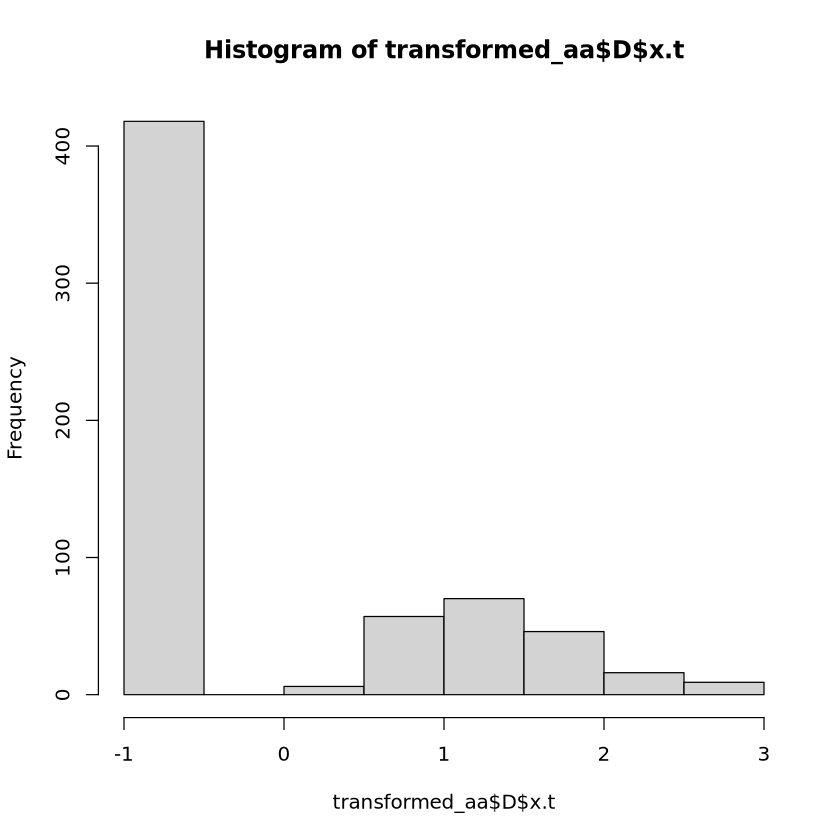

In [229]:
hist()
hist(transformed_aa$D$x.t)

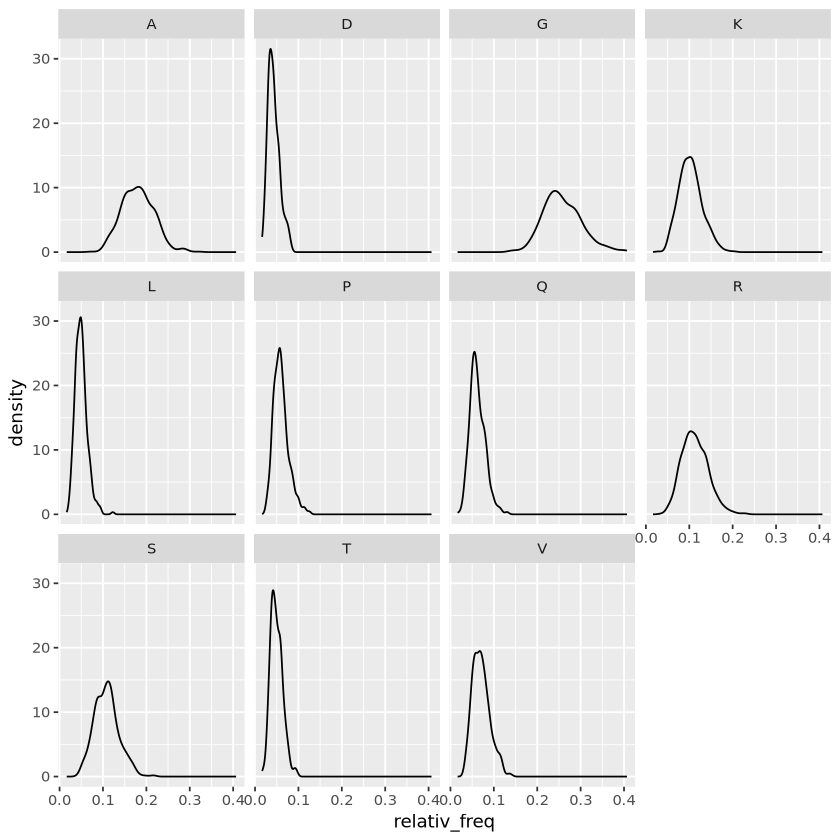

In [181]:
ggplot(cdr3_freq_L_P[[1]], aes(relativ_freq)) + 
       geom_density()+
       facet_wrap(~AA)

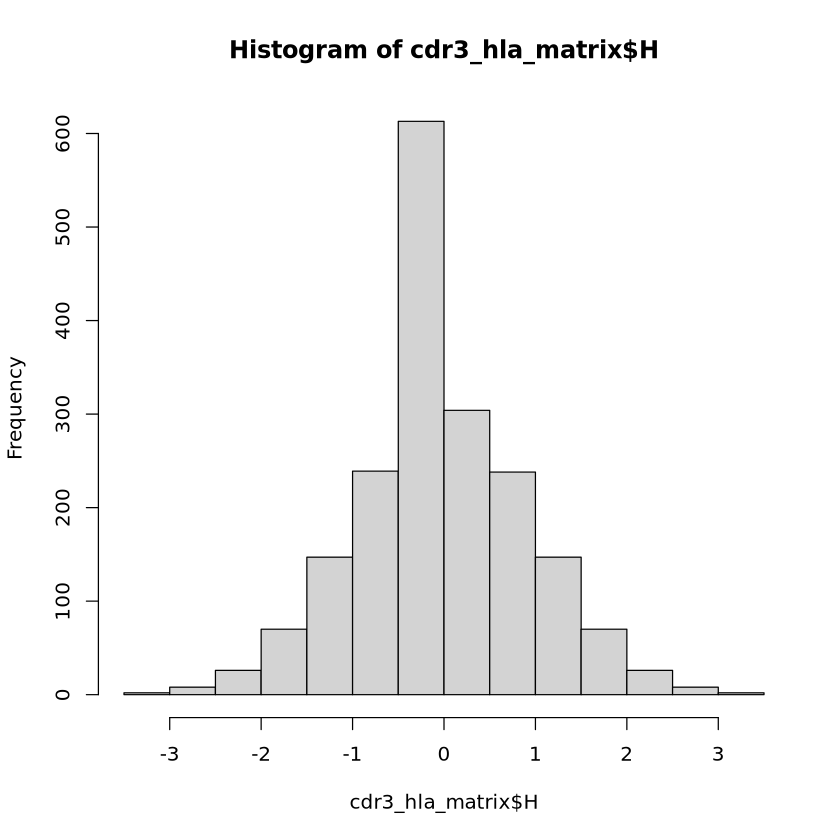

In [289]:
hist(cdr3_hla_matrix$H)

In [337]:
formula_full

cbind(G, V, L, P, D, A, R, Q, S, I, T, Y, E, W, H, N, K, M, F) ~ 
    allele_P + allele_V + allele_G + allele_L + PC1 + PC2 + PC3

In [338]:
mod1_mvlm <- mvlm(formula_full, data=cdr3_hla_matrix) 
mod1_mvlm$pseudo.rsq["Omnibus Effect",1]

Omnibus Effect 
     0.1445395

In [305]:
Y_mat <- as.matrix(cdr3_hla_matrix[aa_columns])
mvmod <- lm(Y ~ allele_G + allele_F + allele_S + allele_H + allele_R   + 
        PC1 + PC2 + PC3, data=cdr3_hla_matrix) 
coef(mvmod)
summary(mvmod)

(Intercept)    allele_G    allele_F    allele_S    allele_H    allele_R 
-0.14121600  0.08887308  0.03425445  0.03958191  0.08056168  0.06556505 
        PC1         PC2         PC3 
-2.10773174 -2.19518471 -0.24683585


Call:
lm(formula = Y ~ allele_G + allele_F + allele_S + allele_H + 
    allele_R + PC1 + PC2 + PC3, data = cdr3_hla_matrix)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.4680 -0.5755 -0.0024  0.5673  3.4644 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)
(Intercept) -0.14122    0.25577  -0.552    0.581
allele_G     0.08887    0.12621   0.704    0.481
allele_F     0.03425    0.10366   0.330    0.741
allele_S     0.03958    0.12478   0.317    0.751
allele_H     0.08056    0.06629   1.215    0.224
allele_R     0.06557    0.15798   0.415    0.678
PC1         -2.10773    5.09515  -0.414    0.679
PC2         -2.19518    1.99911  -1.098    0.272
PC3         -0.24684    2.97357  -0.083    0.934

Residual standard error: 0.9354 on 1891 degrees of freedom
Multiple R-squared:  0.00274,	Adjusted R-squared:  -0.001479 
F-statistic: 0.6495 on 8 and 1891 DF,  p-value: 0.7363


In [271]:
ybar <- colMeans(Y) 
n <- nrow(Y) 
m <- ncol(Y) 
Ybar <- matrix(ybar, n, m, byrow=TRUE) 
SSCP.T <- crossprod(Y- Ybar) 
SSCP.R <- crossprod(mvmod$fitted.values- Ybar) 
SSCP.E <- crossprod(Y- mvmod$fitted.values)

cbind(G, K, V, R, S, F, A, E, T, D, L, W, Y, P, N, Q, M, I, H) ~ 
    allele_F + allele_G + allele_H + allele_R + allele_S + allele_Y + 
        PC1 + PC2 + PC3

### Trying applied mixed models

In [8]:
cdr3 <- fread('../data/cdr3_freq_healthy_and_ibd_v2.tsv')

In [10]:
cdr3_K <- cdr3[AA == 'K']

In [11]:
cdr3_K

patient_id length IMGT   AA total_AA_count total_IMGT_count relativ_freq
1      H0         12     P106   K    7             1132            0.006183746 
2      H0         12     P107   K  290             5457            0.053142752 
3      H0         12     P108   K  190            11360            0.016725352 
4      H0         12     P109   K  170            14246            0.011933174 
5      H0         12     P113   K  165            11528            0.014312977 
6      H0         12     P114   K   79             5661            0.013955132 
7      H0         12     P115   K  115             1523            0.075508864 
8      H0         12     P116   K   36              538            0.066914498 
9      H0         13     P106   K   17             1941            0.008758372 
10     H0         13     P107   K  612            10730            0.057036347 
11     H0         13     P108   K  460            23850            0.019287212 
12     H0         13     P109   K  458            32807            0.013960435 
13     H0         13     P110   K  283            30715            0.009213739 
14     H0         13     P113   K  370            22185            0.016677936 
15     H0         13     P114   K  181             8533            0.021211766 
16     H0         13     P115   K  127             1672            0.075956938 
17     H0         13     P116   K   40              488            0.081967213 
18     H0         14     P106   K    6             1502            0.003994674 
19     H0         14     P107   K  771            12078            0.063835072 
20     H0         14     P108   K  684            32704            0.020914873 
21     H0         14     P109   K  570            47710            0.011947181 
22     H0         14     P110   K  308            47328            0.006507776 
23     H0         14     P112   K  500            42596            0.011738191 
24     H0         14     P113   K  458            27468            0.016673948 
25     H0         14     P114   K  188             8835            0.021279004 
26     H0         14     P115   K   86             1232            0.069805195 
27     H0         14     P116   K   33              281            0.117437722 
28     H0         15     P107   K  573             9535            0.060094389 
29     H0         15     P108   K  695            31807            0.021850536 
30     H0         15     P109   K  619            51431            0.012035543 
⋮      ⋮          ⋮      ⋮      ⋮  ⋮              ⋮                ⋮           
127794 I999       16     P107   K  113             2921            0.038685382 
127795 I999       16     P108   K  180            11407            0.015779784 
127796 I999       16     P109   K  180            18683            0.009634427 
127797 I999       16     P110   K   78            18683            0.004174918 
127798 I999       16     P111   K   82            18685            0.004388547 
127799 I999       16     P112   K  149            14648            0.010172037 
127800 I999       16     P112.1 K  133            18242            0.007290867 
127801 I999       16     P113   K  122             7961            0.015324708 
127802 I999       16     P114   K   27             2200            0.012272727 
127803 I999       16     P115   K   20              219            0.091324201 
127804 I999       17     P107   K   41             1222            0.033551555 
127805 I999       17     P108   K   74             5250            0.014095238 
127806 I999       17     P109   K   75             8856            0.008468835 
127807 I999       17     P110   K   72             8856            0.008130081 
127808 I999       17     P111   K   34             8856            0.003839205 
127809 I999       17     P111.1 K   50             8858            0.005644615 
127810 I999       17     P112   K   86             6359            0.013524139 
127811 I999       17     P112.1 K   62             8420            0.007363420 
127812 

In [32]:
cdr3_plot <- ggplot(cdr3, aes(x = IMGT, y = log10(relativ_freq), group = patient_id)) +
    geom_line() +
    facet_wrap(~AA)

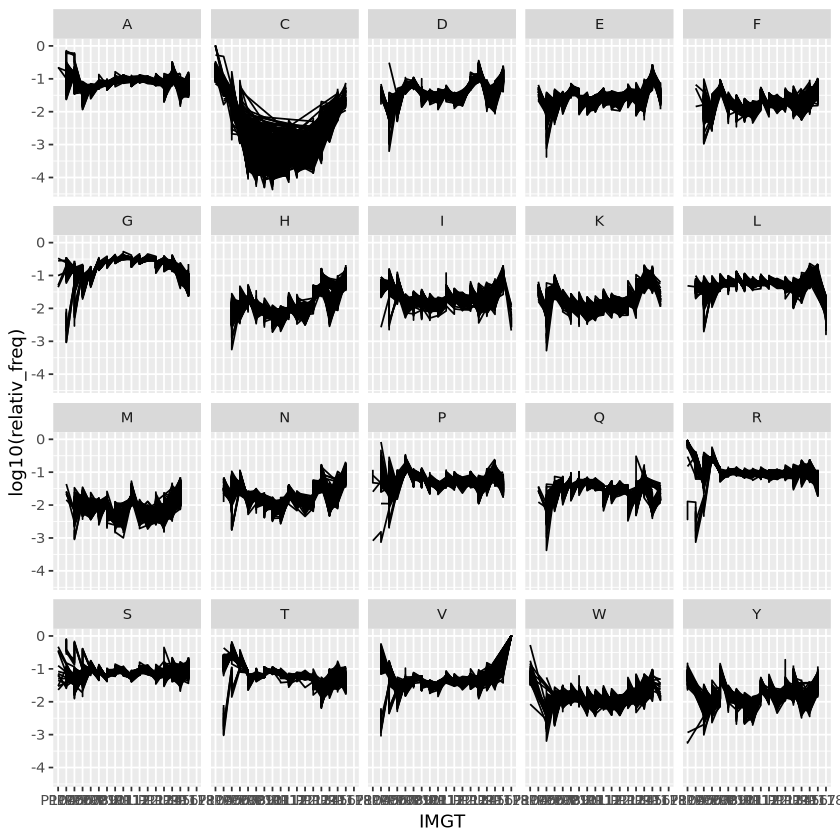

In [33]:
cdr3_plot

In [36]:
mix_mod1 <- lmer(relativ_freq ~ IMGT + length + (1 | patient_id), data = cdr3_K)

In [37]:
summary(mix_mod1)


Correlation matrix not shown by default, as p = 17 > 12.
Use print(obj, correlation=TRUE)  or
    vcov(obj)        if you need it




Linear mixed model fit by REML ['lmerMod']
Formula: relativ_freq ~ IMGT + length + (1 | patient_id)
   Data: cdr3_K

REML criterion at convergence: -887593.9

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-7.6126 -0.3052 -0.0294  0.2886 15.8673 

Random effects:
 Groups     Name        Variance  Std.Dev.
 patient_id (Intercept) 1.886e-06 0.001373
 Residual               5.536e-05 0.007440
Number of obs: 127823, groups:  patient_id, 1922

Fixed effects:
              Estimate Std. Error t value
(Intercept)  1.802e-02  1.021e-03  17.654
IMGTP106    -3.276e-02  1.015e-03 -32.278
IMGTP107     8.773e-03  1.012e-03   8.672
IMGTP108    -2.361e-02  1.012e-03 -23.342
IMGTP109    -3.064e-02  1.012e-03 -30.289
IMGTP110    -3.349e-02  1.012e-03 -33.088
IMGTP111    -3.783e-02  1.014e-03 -37.312
IMGTP111.1  -3.836e-02  1.018e-03 -37.675
IMGTP112    -2.911e-02  1.013e-03 -28.739
IMGTP112.1  -3.360e-02  1.015e-03 -33.091
IMGTP112.2  -3.699e-02  1.026e-03 -36.070
IMGTP113    -2.397e-02  1

Loading required package: arm

Loading required package: MASS


Attaching package: ‘MASS’


The following object is masked from ‘package:patchwork’:

    area


The following object is masked from ‘package:dplyr’:

    select



arm (Version 1.14-4, built: 2024-4-1)


Working directory is /work_beegfs/sukmb667/projects/cdr3-qtl/healthy_and_ibd/scripts



Attaching package: ‘arm’


The following object is masked from ‘package:corrplot’:

    corrplot


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 1.8 GiB”
Warning message:
“executing %dopar% sequentially: no parallel backend registered”


fit          upr         lwr          
1      0.007186587  0.01677841  -0.0019207058
2      0.048117265  0.05870865   0.0384140634
3      0.016320358  0.02580695   0.0061837450
4      0.008697484  0.01791632  -0.0003718437
5      0.015242652  0.02508578   0.0055941538
6      0.019176473  0.02785740   0.0094980834
7      0.080411903  0.08989137   0.0704670874
8      0.078854532  0.08893042   0.0695050769
9      0.008564038  0.01809012  -0.0009420476
10     0.049709903  0.05910423   0.0409487821
11     0.017756423  0.02740980   0.0080557343
12     0.010345766  0.01993970   0.0006714240
13     0.007969306  0.01711755  -0.0017823111
14     0.016713264  0.02688167   0.0073644221
15     0.020746105  0.03064128   0.0113959808
16     0.081639935  0.09087395   0.0721214819
17     0.080647962  0.08980831   0.0718760424
18     0.010418428  0.02012872   0.0003163673
19     0.052038311  0.06165991   0.0422769467
20     0.019019572  0.02919629   0.0092722693
21     0.012681635  0.02183366   0.0029228201
22     0.009920913  0.01886409   0.0005990635
23     0.013681809  0.02349088   0.0041898308
24     0.019015246  0.02891978   0.0089152867
25     0.022429466  0.03210632   0.0129466829
26     0.083648636  0.09256451   0.0739379828
27     0.082151173  0.09227710   0.0727507472
28     0.054010513  0.06333581   0.0445663994
29     0.021168087  0.03091161   0.0112424544
30     0.014217261  0.02399686   0.0039112818
⋮      ⋮            ⋮           ⋮            
127794 0.0476382981 0.056078467  3.868432e-02
127795 0.0150466071 0.024606280  5.065846e-03
127796 0.0079111772 0.017124830 -2.078656e-03
127797 0.0053158069 0.014038868 -4.409697e-03
127798 0.0008675249 0.009668965 -9.008500e-03
127799 0.0092628086 0.019307756 -5.771887e-04
127800 0.0045773480 0.014373580 -4.974120e-03
127801 0.0149587116 0.024175008  5.455313e-03
127802 0.0182046191 0.027926615  8.610575e-03
127803 0.0788758044 0.088438700  6.884701e-02
127804 0.0492753041 0.058731656  3.957731e-02
127805 0.0169186307 0.025937657  6.790395e-03
127806 0.0098815459 0.019803333 -7.121047e-05
127807 0.0065027866 0.016209194 -2.822657e-03
127808 0.0025285042 0.012137224 -7.353879e-03
127809 0.0015937696 0.011192875 -7.610347e-03
127810 0.0107310008 0.020523453  2.003578e-03
127811 0.0065589226 0.016844465 -3.401704e-03
127812 0.0164167923 0.026434199  7.675654e-03
127813 0.0193171549 0.029127298  9.615920e-03
127814 0.0503148441 0.059678473  4.073629e-02
127815 0.0183760736 0.027319011  8.392405e-03
127816 0.0112711228 0.019922940  1.648077e-03
127817 0.0083964117 0.017597636 -7.470672e-04
127818 0.0039615071 0.014117928 -5.342157e-03
127819 0.0036756578 0.013162492 -5.566636e-03
127820 0.0126296606 0.022141344  2.951536e-03
127821 0.0081486869 0.018761740 -1.054748e-03
127822 0.0051627588 0.013924353 -4.452548e-03
127823 0.0182229393 0.027454960  8.563379e-03

groupFctr  groupID term        mean          median        sd          
1    patient_id H0      (Intercept)  1.153191e-03  1.129954e-03 0.0007588015
2    patient_id H1      (Intercept)  8.104722e-04  8.166952e-04 0.0007120794
3    patient_id H10     (Intercept)  4.226662e-04  4.173701e-04 0.0008029524
4    patient_id H100    (Intercept)  1.367784e-03  1.383755e-03 0.0007182256
5    patient_id H101    (Intercept) -1.135653e-03 -1.144945e-03 0.0007946628
6    patient_id H102    (Intercept) -2.537014e-03 -2.493967e-03 0.0008239631
7    patient_id H103    (Intercept) -5.937011e-04 -5.903294e-04 0.0007238959
8    patient_id H104    (Intercept)  1.578478e-03  1.561160e-03 0.0007459905
9    patient_id H105    (Intercept) -7.362066e-04 -7.555156e-04 0.0007056184
10   patient_id H106    (Intercept) -8.942475e-04 -8.741586e-04 0.0007620751
11   patient_id H107    (Intercept)  1.949274e-03  1.871805e-03 0.0007527230
12   patient_id H108    (Intercept) -1.646374e-04 -1.653242e-04 0.0007810660
13   patient_id H109    (Intercept)  7.548888e-04  7.324075e-04 0.0006837879
14   patient_id H11     (Intercept)  1.734313e-03  1.717614e-03 0.0007323486
15   patient_id H110    (Intercept) -2.457954e-05  3.127615e-05 0.0007972896
16   patient_id H111    (Intercept) -7.334682e-04 -7.763857e-04 0.0007507339
17   patient_id H112    (Intercept) -7.747684e-04 -8.410836e-04 0.0007219585
18   patient_id H113    (Intercept)  4.346663e-04  4.714730e-04 0.0008264273
19   patient_id H114    (Intercept) -1.227646e-03 -1.167187e-03 0.0007490250
20   patient_id H115    (Intercept)  8.472057e-06 -1.643984e-05 0.0007790026
21   patient_id H116    (Intercept) -8.438530e-04 -8.622871e-04 0.0007416738
22   patient_id H117    (Intercept) -3.134419e-04 -3.194660e-04 0.0007421315
23   patient_id H118    (Intercept)  2.679226e-04  3.116428e-04 0.0007829063
24   patient_id H119    (Intercept) -5.577056e-04 -5.367350e-04 0.0007874038
25   patient_id H12     (Intercept) -2.205394e-04 -2.449273e-04 0.0007124524
26   patient_id H120    (Intercept)  9.361707e-04  9.916607e-04 0.0007951049
27   patient_id H121    (Intercept) -1.426825e-03 -1.497960e-03 0.0007418675
28   patient_id H122    (Intercept) -1.600775e-04 -1.400960e-04 0.0008090488
29   patient_id H123    (Intercept)  8.786594e-05  4.501132e-05 0.0007660169
30   patient_id H124    (Intercept) -3.340510e-04 -3.783585e-04 0.0007255436
⋮    ⋮          ⋮       ⋮           ⋮             ⋮             ⋮           
1893 patient_id I970    (Intercept)  0.0001305855  0.0002488619 0.0007932593
1894 patient_id I972    (Intercept)  0.0015929303  0.0015377636 0.0008242714
1895 patient_id I973    (Intercept) -0.0006727634 -0.0006635365 0.0007713221
1896 patient_id I974    (Intercept) -0.0003875024 -0.0004721666 0.0007435376
1897 patient_id I975    (Intercept)  0.0004304005  0.0003777655 0.0007992997
1898 patient_id I976    (Intercept)  0.0011209755  0.0010873547 0.0007900640
1899 patient_id I977    (Intercept)  0.0005444749  0.0005486629 0.0007139291
1900 patient_id I978    (Intercept) -0.0008297167 -0.0007925246 0.0007925158
1901 patient_id I979    (Intercept) -0.0001588775 -0.0001554262 0.0007601159
1902 patient_id I98     (Intercept)  0.0001409917  0.0001309384 0.0007389140
1903 patient_id I980    (Intercept)  0.0009234092  0.0009020584 0.0007911532
1904 patient_id I982    (Intercept)  0.0012161564  0.0012226598 0.0006777828
1905 patient_id I983    (Intercept) -0.0002547451 -0.0002639851 0.0007771666
1906 patient_id I984    (Intercept)  0.0026119314  0.0026388687 0.0008291465
1907 patient_id I985    (Intercept) -0.0005719448 -0.0005627837 0.0007406732
1908 patient_id I986    (Intercept)  0.0011418777  0.0011625015 0.0007978365
1909 patient_id I987    (Intercept) -0.0002685518 -0.0002780894 0.0007297273
1910 patient_id I988    (Intercept) -0.0001212209 -0.0001725522 0.0007200721
1911 patient_id I989    (Intercept) -0.0002422127 -0.0002259265 0.0007958690
1912 patient_id I99     (Intercept) -0.0015189705 -0.0015193645 0.0007879747
1

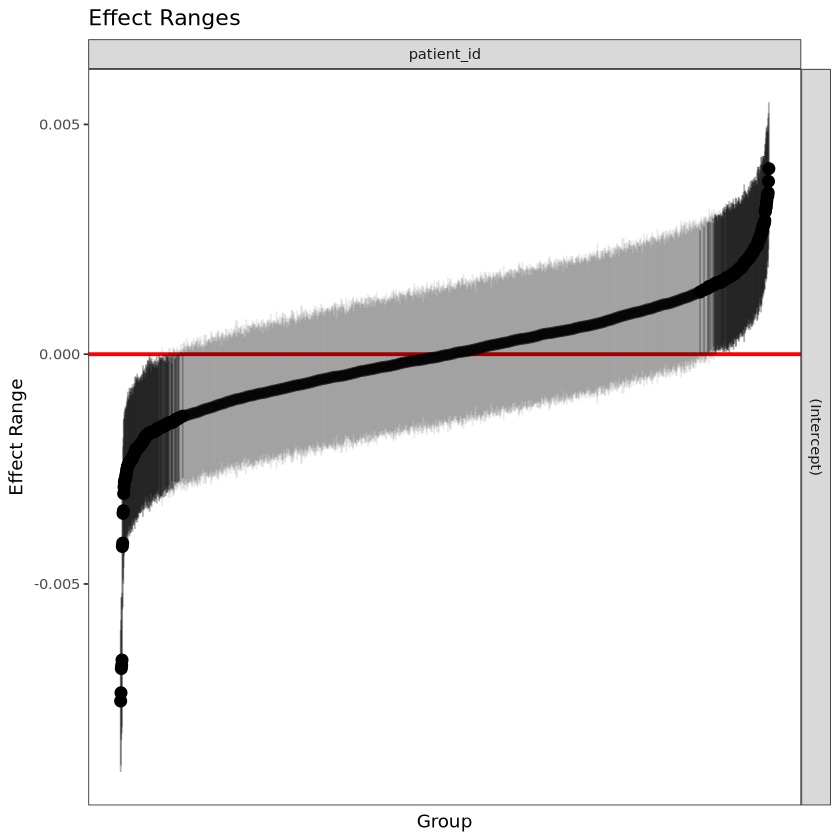

In [40]:
predictInterval(mix_mod1)   # for various model predictions, possibly with new data

REsim(mix_mod1)             # mean, median and sd of the random effect estimates

plotREsim(REsim(mix_mod1)) 

In [256]:
hla_sites_patients %>% filter(gene=='A') %>% arrange(site)

site AA n_allele_carriers patient_id gene homo_hetero variat  n_variat
1      9    F  2490              H0         A    1           F S Y T 4       
2      9    F  2490              H10        A    1           F S Y T 4       
3      9    F  2490              H100       A    1           F S Y T 4       
4      9    F  2490              H101       A    2           F S Y T 4       
5      9    F  2490              H102       A    1           F S Y T 4       
6      9    F  2490              H104       A    1           F S Y T 4       
7      9    F  2490              H105       A    1           F S Y T 4       
8      9    F  2490              H106       A    1           F S Y T 4       
9      9    F  2490              H107       A    2           F S Y T 4       
10     9    F  2490              H108       A    1           F S Y T 4       
11     9    F  2490              H11        A    1           F S Y T 4       
12     9    F  2490              H110       A    1           F S Y T 4       
13     9    F  2490              H111       A    1           F S Y T 4       
14     9    F  2490              H112       A    1           F S Y T 4       
15     9    F  2490              H113       A    2           F S Y T 4       
16     9    F  2490              H114       A    1           F S Y T 4       
17     9    F  2490              H115       A    1           F S Y T 4       
18     9    F  2490              H116       A    2           F S Y T 4       
19     9    F  2490              H117       A    2           F S Y T 4       
20     9    F  2490              H119       A    1           F S Y T 4       
21     9    F  2490              H12        A    2           F S Y T 4       
22     9    F  2490              H120       A    1           F S Y T 4       
23     9    F  2490              H121       A    2           F S Y T 4       
24     9    F  2490              H122       A    2           F S Y T 4       
25     9    F  2490              H123       A    1           F S Y T 4       
26     9    F  2490              H124       A    2           F S Y T 4       
27     9    F  2490              H125       A    1           F S Y T 4       
28     9    F  2490              H128       A    1           F S Y T 4       
29     9    F  2490              H129       A    2           F S Y T 4       
30     9    F  2490              H130       A    2           F S Y T 4       
⋮      ⋮    ⋮  ⋮                 ⋮          ⋮    ⋮           ⋮       ⋮       
139022 334  V  3225              I966       A    2           V M     2       
139023 334  V  3225              I968       A    2           V M     2       
139024 334  V  3225              I97        A    2           V M     2       
139025 334  V  3225              I970       A    2           V M     2       
139026 334  V  3225              I972       A    2           V M     2       
139027 334  V  3225              I973       A    1           V M     2       
139028 334  V  3225              I974       A    1           V M     2       
139029 334  V  3225              I975       A    2           V M     2       
139030 334  V  3225              I976       A    2           V M     2       
139031 334  V  3225              I977       A    2           V M     2       
139032 334  V  3225              I978       A    2           V M     2       
139033 334  V  3225              I979       A    1           V M     2       
139034 334  V  3225              I98        A    2           V M     2       
139035 334  V  3225              I980       A    2           V M     2       
139036 334  V  3225              I983       A    1           V M     2       
139037 334  V  3225              I984       A    2           V M     2       
139038 334  V  3225              I985       A    1           V M     2       
139039 334  V  3225              I986       A    2           V M     2       
139040 334  V  3225              I987       A    2           V M     2       
139041 334  V  3225          

In [289]:
hla_sites_complete <- hla_sites_patients %>% group_by(gene, site) %>% 
    dplyr::select(gene,site,patient_id,AA, homo_hetero) %>% 
    complete(patient_id, AA) %>% 
    ungroup() %>% 
    rename(allele = AA)
hla_sites_complete[is.na(hla_sites_complete)] <- 0

In [290]:
hla_sites_complete

gene site patient_id allele homo_hetero
1       A    9    H0         F      1          
2       A    9    H0         S      1          
3       A    9    H0         T      0          
4       A    9    H0         Y      0          
5       A    9    H1         F      0          
6       A    9    H1         S      0          
7       A    9    H1         T      0          
8       A    9    H1         Y      2          
9       A    9    H10        F      1          
10      A    9    H10        S      1          
11      A    9    H10        T      0          
12      A    9    H10        Y      0          
13      A    9    H100       F      1          
14      A    9    H100       S      0          
15      A    9    H100       T      0          
16      A    9    H100       Y      1          
17      A    9    H101       F      2          
18      A    9    H101       S      0          
19      A    9    H101       T      0          
20      A    9    H101       Y      0          
21      A    9    H102       F      1          
22      A    9    H102       S      1          
23      A    9    H102       T      0          
24      A    9    H102       Y      0          
25      A    9    H103       F      0          
26      A    9    H103       S      0          
27      A    9    H103       T      0          
28      A    9    H103       Y      2          
29      A    9    H104       F      1          
30      A    9    H104       S      1          
⋮       ⋮    ⋮    ⋮          ⋮      ⋮          
1196698 DRB1 233  I986       R      2          
1196699 DRB1 233  I986       T      0          
1196700 DRB1 233  I987       R      1          
1196701 DRB1 233  I987       T      1          
1196702 DRB1 233  I988       R      2          
1196703 DRB1 233  I988       T      0          
1196704 DRB1 233  I989       R      0          
1196705 DRB1 233  I989       T      2          
1196706 DRB1 233  I99        R      0          
1196707 DRB1 233  I99        T      2          
1196708 DRB1 233  I990       R      1          
1196709 DRB1 233  I990       T      1          
1196710 DRB1 233  I991       R      0          
1196711 DRB1 233  I991       T      2          
1196712 DRB1 233  I992       R      0          
1196713 DRB1 233  I992       T      2          
1196714 DRB1 233  I993       R      1          
1196715 DRB1 233  I993       T      1          
1196716 DRB1 233  I994       R      0          
1196717 DRB1 233  I994       T      2          
1196718 DRB1 233  I995       R      1          
1196719 DRB1 233  I995       T      1          
1196720 DRB1 233  I996       R      0          
1196721 DRB1 233  I996       T      2          
1196722 DRB1 233  I997       R      1          
1196723 DRB1 233  I997       T      1          
1196724 DRB1 233  I998       R      2          
1196725 DRB1 233  I998       T      0          
1196726 DRB1 233  I999       R      1          
1196727 DRB1 233  I999       T      1

In [331]:
cdr3_complete <- cdr3 %>% dplyr::select(patient_id, length, IMGT, AA, relativ_freq) %>%
    group_by(length, IMGT) %>% 
    filter(!IMGT %in% c('P104','P118')) %>%
    complete(patient_id, AA) %>% ungroup()
cdr3_complete[is.na(cdr3_complete)] <- 0

In [333]:
cdr3_complete

length IMGT patient_id AA relativ_freq
1       12     P105 H1         A  0.09448819  
2       12     P105 H1         C  0.00000000  
3       12     P105 H1         D  0.00000000  
4       12     P105 H1         E  0.00000000  
5       12     P105 H1         F  0.00000000  
6       12     P105 H1         G  0.22834646  
7       12     P105 H1         I  0.00000000  
8       12     P105 H1         K  0.00000000  
9       12     P105 H1         L  0.00000000  
10      12     P105 H1         M  0.00000000  
11      12     P105 H1         N  0.00000000  
12      12     P105 H1         P  0.04724409  
13      12     P105 H1         Q  0.00000000  
14      12     P105 H1         R  0.25196850  
15      12     P105 H1         S  0.05511811  
16      12     P105 H1         T  0.16535433  
17      12     P105 H1         V  0.15748031  
18      12     P105 H1         Y  0.00000000  
19      12     P105 H101       A  0.05128205  
20      12     P105 H101       C  0.00000000  
21      12     P105 H101       D  0.00000000  
22      12     P105 H101       E  0.00000000  
23      12     P105 H101       F  0.00000000  
24      12     P105 H101       G  0.29059829  
25      12     P105 H101       I  0.00000000  
26      12     P105 H101       K  0.00000000  
27      12     P105 H101       L  0.00000000  
28      12     P105 H101       M  0.00000000  
29      12     P105 H101       N  0.00000000  
30      12     P105 H101       P  0.00000000  
⋮       ⋮      ⋮    ⋮          ⋮  ⋮           
2734676 18     P115 I886       S  0.06930693  
2734677 18     P115 I886       T  0.06930693  
2734678 18     P115 I886       V  0.07920792  
2734679 18     P115 I886       W  0.00000000  
2734680 18     P115 I924       A  0.15652174  
2734681 18     P115 I924       D  0.00000000  
2734682 18     P115 I924       E  0.00000000  
2734683 18     P115 I924       G  0.35652174  
2734684 18     P115 I924       K  0.06086957  
2734685 18     P115 I924       L  0.07826087  
2734686 18     P115 I924       P  0.00000000  
2734687 18     P115 I924       Q  0.07826087  
2734688 18     P115 I924       R  0.06956522  
2734689 18     P115 I924       S  0.13043478  
2734690 18     P115 I924       T  0.00000000  
2734691 18     P115 I924       V  0.06956522  
2734692 18     P115 I924       W  0.00000000  
2734693 18     P115 I952       A  0.23200000  
2734694 18     P115 I952       D  0.05600000  
2734695 18     P115 I952       E  0.00000000  
2734696 18     P115 I952       G  0.25600000  
2734697 18     P115 I952       K  0.07200000  
2734698 18     P115 I952       L  0.00000000  
2734699 18     P115 I952       P  0.06400000  
2734700 18     P115 I952       Q  0.00000000  
2734701 18     P115 I952       R  0.10400000  
2734702 18     P115 I952       S  0.10400000  
2734703 18     P115 I952       T  0.05600000  
2734704 18     P115 I952       V  0.05600000  
2734705 18     P115 I952       W  0.00000000

In [371]:
hla_gene_site <- hla_sites_complete %>% filter(gene == 'DRB1', site == 13)
hla_gene_site

gene site patient_id allele homo_hetero
1     DRB1 13   H0         F      0          
2     DRB1 13   H0         G      0          
3     DRB1 13   H0         H      0          
4     DRB1 13   H0         R      2          
5     DRB1 13   H0         S      0          
6     DRB1 13   H0         Y      0          
7     DRB1 13   H1         F      0          
8     DRB1 13   H1         G      0          
9     DRB1 13   H1         H      0          
10    DRB1 13   H1         R      1          
11    DRB1 13   H1         S      0          
12    DRB1 13   H1         Y      1          
13    DRB1 13   H10        F      0          
14    DRB1 13   H10        G      0          
15    DRB1 13   H10        H      0          
16    DRB1 13   H10        R      0          
17    DRB1 13   H10        S      2          
18    DRB1 13   H10        Y      0          
19    DRB1 13   H100       F      0          
20    DRB1 13   H100       G      0          
21    DRB1 13   H100       H      0          
22    DRB1 13   H100       R      0          
23    DRB1 13   H100       S      2          
24    DRB1 13   H100       Y      0          
25    DRB1 13   H101       F      0          
26    DRB1 13   H101       G      0          
27    DRB1 13   H101       H      0          
28    DRB1 13   H101       R      1          
29    DRB1 13   H101       S      1          
30    DRB1 13   H101       Y      0          
⋮     ⋮    ⋮    ⋮          ⋮      ⋮          
11371 DRB1 13   I995       F      1          
11372 DRB1 13   I995       G      0          
11373 DRB1 13   I995       H      0          
11374 DRB1 13   I995       R      0          
11375 DRB1 13   I995       S      1          
11376 DRB1 13   I995       Y      0          
11377 DRB1 13   I996       F      1          
11378 DRB1 13   I996       G      0          
11379 DRB1 13   I996       H      1          
11380 DRB1 13   I996       R      0          
11381 DRB1 13   I996       S      0          
11382 DRB1 13   I996       Y      0          
11383 DRB1 13   I997       F      1          
11384 DRB1 13   I997       G      0          
11385 DRB1 13   I997       H      0          
11386 DRB1 13   I997       R      0          
11387 DRB1 13   I997       S      1          
11388 DRB1 13   I997       Y      0          
11389 DRB1 13   I998       F      0          
11390 DRB1 13   I998       G      1          
11391 DRB1 13   I998       H      0          
11392 DRB1 13   I998       R      0          
11393 DRB1 13   I998       S      1          
11394 DRB1 13   I998       Y      0          
11395 DRB1 13   I999       F      0          
11396 DRB1 13   I999       G      0          
11397 DRB1 13   I999       H      0          
11398 DRB1 13   I999       R      1          
11399 DRB1 13   I999       S      1          
11400 DRB1 13   I999       Y      0

In [386]:
cdr3_IMGT_AA <- cdr3_complete %>% filter(IMGT == 'P113')

In [407]:
cdr3_IMGT_AA %>% arrange(relativ_freq)

length IMGT patient_id AA relativ_freq
1      12     P113 H0         C  0           
2      12     P113 H10        C  0           
3      12     P113 H100       C  0           
4      12     P113 H101       C  0           
5      12     P113 H102       C  0           
6      12     P113 H103       C  0           
7      12     P113 H104       C  0           
8      12     P113 H105       C  0           
9      12     P113 H106       C  0           
10     12     P113 H108       C  0           
11     12     P113 H109       C  0           
12     12     P113 H110       C  0           
13     12     P113 H111       C  0           
14     12     P113 H112       C  0           
15     12     P113 H115       C  0           
16     12     P113 H116       C  0           
17     12     P113 H117       C  0           
18     12     P113 H118       C  0           
19     12     P113 H119       C  0           
20     12     P113 H12        C  0           
21     12     P113 H120       C  0           
22     12     P113 H121       C  0           
23     12     P113 H122       C  0           
24     12     P113 H123       C  0           
25     12     P113 H124       C  0           
26     12     P113 H125       C  0           
27     12     P113 H126       C  0           
28     12     P113 H128       C  0           
29     12     P113 H129       C  0           
30     12     P113 H131       C  0           
⋮      ⋮      ⋮    ⋮          ⋮  ⋮           
269051 12     P113 H647       G  0.3328436   
269052 12     P113 I457       G  0.3329389   
269053 12     P113 H59        G  0.3334931   
269054 12     P113 H189       G  0.3336593   
269055 12     P113 I118       G  0.3337868   
269056 12     P113 I1068      G  0.3337960   
269057 12     P113 I729       G  0.3338188   
269058 12     P113 I69        G  0.3339656   
269059 12     P113 H620       G  0.3341563   
269060 12     P113 H480       G  0.3358346   
269061 12     P113 I68        G  0.3359100   
269062 12     P113 I907       G  0.3359312   
269063 12     P113 I318       G  0.3360924   
269064 12     P113 H688       G  0.3376754   
269065 12     P113 H200       G  0.3389350   
269066 12     P113 I595       G  0.3393543   
269067 12     P113 I245       G  0.3397606   
269068 12     P113 I545       G  0.3397927   
269069 12     P113 I524       G  0.3398527   
269070 12     P113 H641       G  0.3402074   
269071 12     P113 I77        G  0.3408965   
269072 12     P113 H202       G  0.3409914   
269073 12     P113 I773       G  0.3418440   
269074 12     P113 I824       G  0.3453619   
269075 12     P113 I130       G  0.3456322   
269076 12     P113 I999       G  0.3505839   
269077 12     P113 I891       G  0.3548505   
269078 12     P113 H15        G  0.3651617   
269079 12     P113 H838       G  0.3694192   
269080 12     P113 H269       G  0.3810547

In [408]:
hla_gene_site_cdr3_IMGT_AA <- right_join(cdr3_IMGT_AA, hla_gene_site, by = 'patient_id', relationship = "many-to-many")

In [416]:
data_for_plot <- hla_gene_site_cdr3_IMGT_AA %>% filter(allele == 'G', length==12) #%>% filter(homo_hetero==2) #%>% pull(patient_id) %>% uniqueN()

In [417]:
data_for_plot

length IMGT patient_id AA relativ_freq gene site allele homo_hetero
1     12     P113 H0         A  0.0843164469 DRB1 13   G      0          
2     12     P113 H0         C  0.0000000000 DRB1 13   G      0          
3     12     P113 H0         D  0.0536953505 DRB1 13   G      0          
4     12     P113 H0         E  0.0280187370 DRB1 13   G      0          
5     12     P113 H0         F  0.0210791117 DRB1 13   G      0          
6     12     P113 H0         G  0.2974496877 DRB1 13   G      0          
7     12     P113 H0         H  0.0131852880 DRB1 13   G      0          
8     12     P113 H0         I  0.0197779320 DRB1 13   G      0          
9     12     P113 H0         K  0.0143129771 DRB1 13   G      0          
10    12     P113 H0         L  0.0562109646 DRB1 13   G      0          
11    12     P113 H0         M  0.0077203331 DRB1 13   G      0          
12    12     P113 H0         N  0.0142262318 DRB1 13   G      0          
13    12     P113 H0         P  0.0621096461 DRB1 13   G      0          
14    12     P113 H0         Q  0.0273247745 DRB1 13   G      0          
15    12     P113 H0         R  0.0942054129 DRB1 13   G      0          
16    12     P113 H0         S  0.0595940319 DRB1 13   G      0          
17    12     P113 H0         T  0.0576856350 DRB1 13   G      0          
18    12     P113 H0         V  0.0572519084 DRB1 13   G      0          
19    12     P113 H0         W  0.0145732130 DRB1 13   G      0          
20    12     P113 H0         Y  0.0172623178 DRB1 13   G      0          
21    12     P113 H1         A  0.0842916641 DRB1 13   G      0          
22    12     P113 H1         C  0.0006216199 DRB1 13   G      0          
23    12     P113 H1         D  0.0577484926 DRB1 13   G      0          
24    12     P113 H1         E  0.0334431529 DRB1 13   G      0          
25    12     P113 H1         F  0.0174053584 DRB1 13   G      0          
26    12     P113 H1         G  0.3086343010 DRB1 13   G      0          
27    12     P113 H1         H  0.0116242929 DRB1 13   G      0          
28    12     P113 H1         I  0.0183999503 DRB1 13   G      0          
29    12     P113 H1         K  0.0130540188 DRB1 13   G      0          
30    12     P113 H1         L  0.0507863492 DRB1 13   G      0          
⋮     ⋮      ⋮    ⋮          ⋮  ⋮            ⋮    ⋮    ⋮      ⋮          
37971 12     P113 I998       M  0.004771260  DRB1 13   G      1          
37972 12     P113 I998       N  0.013752456  DRB1 13   G      1          
37973 12     P113 I998       P  0.055571148  DRB1 13   G      1          
37974 12     P113 I998       Q  0.024698288  DRB1 13   G      1          
37975 12     P113 I998       R  0.098793152  DRB1 13   G      1          
37976 12     P113 I998       S  0.070165591  DRB1 13   G      1          
37977 12     P113 I998       T  0.052203200  DRB1 13   G      1          
37978 12     P113 I998       V  0.053045187  DRB1 13   G      1          
37979 12     P113 I998       W  0.014313781  DRB1 13   G      1          
37980 12     P113 I998       Y  0.023575639  DRB1 13   G      1          
37981 12     P113 I999       A  0.090967535  DRB1 13   G      0          
37982 12     P113 I999       C  0.000000000  DRB1 13   G      0          
37983 12     P113 I999       D  0.052394728  DRB1 13   G      0          
37984 12     P113 I999       E  0.026679524  DRB1 13   G      0          
37985 12     P113 I999       F  0.014036216  DRB1 13   G      0          
37986 12     P113 I999       G  0.350583949  DRB1 13   G      0          
37987 12     P113 I999       H  0.013821922  DRB1 13   G      0          
37988 12     P113 I999       I  0.010928962  DRB1 13   G      0          
37989 12     P113 I999       K  0.007178828  DRB1 13   G      0          
37990 12     P113 I999       L  0.044144434  DRB1 13   G      0          
37991 12     P113 I999       M  0.003214401  DRB1 13   G      0          
37992 12     P113 I999       N  0.009321761  DRB1 13   G      0          
37993 12  

In [418]:
ggplot(data_for_plot, aes(x = homo_hetero, y = relativ_freq, group= AA, fill = AA)) +
    geom_density(adjust=1.5, position="fill") +
    theme_cowplot() 

Warning message:
“The following aesthetics were dropped during statistical transformation: y.
ℹ This can happen when ggplot fails to infer the correct grouping structure in the data.
ℹ Did you forget to specify a `group` aesthetic or to convert a numerical variable into a factor?”
ERROR while rich displaying an object: Error in `geom_density()`:
! Problem while setting up geom.
ℹ Error occurred in the 1st layer.
Caused by error in `compute_geom_1()`:
! `geom_density()` requires the following missing aesthetics: y.

Traceback:
1. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
2. tryCatchList(expr, classes, parentenv, handlers)
3. tryCatchOne(expr, names, parentenv, handlers[[1L]])
4. doTryCatch(return(

In [163]:
#cdr3_hla_matrix <- hla_gene_site_cdr3_IMGT %>% pivot_wider(names_from = allele, values_from = homo_hetero)

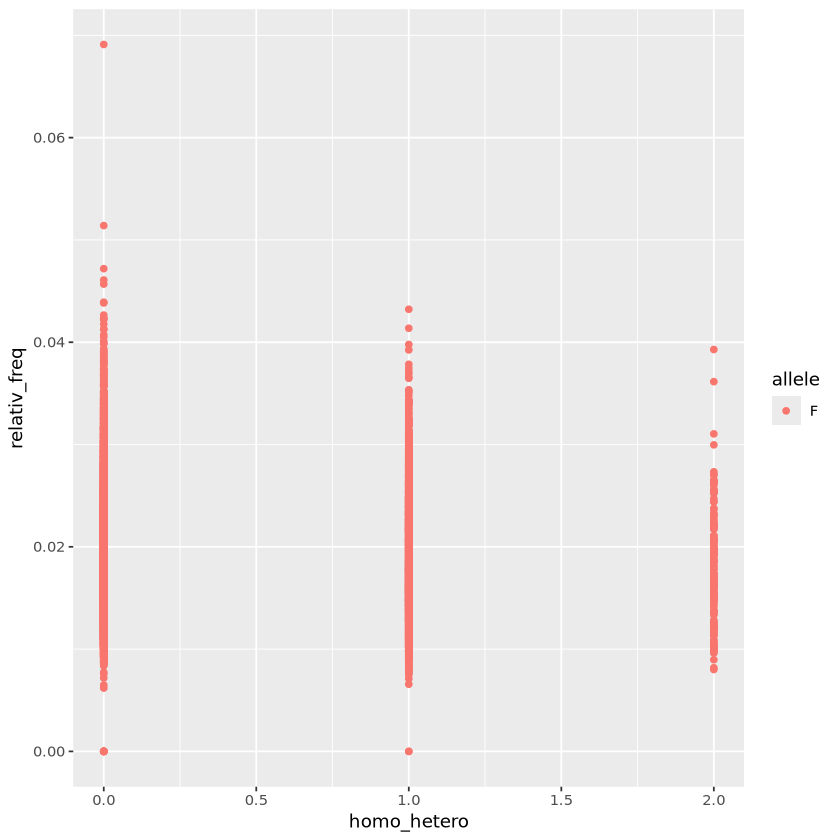

In [385]:
ggplot(hla_gene_site_cdr3_IMGT_AA %>% filter(allele == 'F'), aes(x = homo_hetero, y = relativ_freq, color = allele))+
    geom_point()

In [ ]:
mix_mod_full_2 <- lmer(relativ_freq ~ homo_hetero + (1 + patient_id | allele), data = hla_gene_site_cdr3_IMGT_AA)

In [381]:
summary(mix_mod_full_2)

Linear mixed model fit by REML ['lmerMod']
Formula: relativ_freq ~ homo_hetero + (1 | patient_id)
   Data: hla_gene_site_cdr3_IMGT_AA

REML criterion at convergence: -612408.9

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.5650 -0.7075 -0.1291  0.7024  8.6181 

Random effects:
 Groups     Name        Variance  Std.Dev.
 patient_id (Intercept) 2.760e-06 0.001661
 Residual               2.612e-05 0.005110
Number of obs: 79800, groups:  patient_id, 1900

Fixed effects:
              Estimate Std. Error t value
(Intercept)  1.958e-02  4.360e-05   449.1
homo_hetero -1.236e-16  3.296e-05     0.0

Correlation of Fixed Effects:
            (Intr)
homo_hetero -0.252

In [231]:
help('isSingular')

isSingular                package:lme4                 R Documentation

_T_e_s_t _F_i_t_t_e_d _M_o_d_e_l _f_o_r (_N_e_a_r) _S_i_n_g_u_l_a_r_i_t_y

_D_e_s_c_r_i_p_t_i_o_n:

     Evaluates whether a fitted mixed model is (almost / near)
     singular, i.e., the parameters are on the boundary of the feasible
     parameter space: variances of one or more linear combinations of
     effects are (close to) zero.

_U_s_a_g_e:

     isSingular(x, tol = 1e-4)
     
_A_r_g_u_m_e_n_t_s:

       x: a fitted ‘merMod’ object (result of ‘lmer’ or ‘glmer’).

     tol: numerical tolerance for detecting singularity.

_D_e_t_a_i_l_s:

     Complex mixed-effect models (i.e., those with a large number of
     variance-covariance parameters) frequently result in _singular_
     fits, i.e. estimated variance-covariance matrices with less than
     full rank. Less technically, this means that some "dimensions" of
     the variance-covariance matrix have been estimated as exactly
     zero. For scalar random effects such as intercept-only models, or
     2-dimensional random effects such as intercept+slope models,
     singularity is relatively easy to detect because it leads to
     random-effect variance estimates of (nearly) zero, or estimates of
     correlations that are (almost) exactly -1 or 1. However, for more
     complex models (variance-covariance matrices of dimension >=3)
     singularity can be hard to detect; models can often be singular
     without any of their individual variances being close to zero or
     correlations being close to +/-1.

     This function performs a simple test to determine whether any of
     the random effects covariance matrices of a fitted model are
     singular.  The ‘rePCA’ method provides more detail about the
     singularity pattern, showing the standard deviations of orthogonal
     variance components and the mapping from variance terms in the
     model to orthogonal components (i.e., eigenvector/rotation
     matrices).

     While singular models are statistically well defined (it is
     theoretically sensible for the true maximum likelihood estimate to
     correspond to a singular fit), there are real concerns that (1)
     singular fits correspond to overfitted models that may have poor
     power; (2) chances of numerical problems and mis-convergence are
     higher for singular models (e.g. it may be computationally
     difficult to compute profile confidence intervals for such
     models); (3) standard inferential procedures such as Wald
     statistics and likelihood ratio tests may be inappropriate.

     There is not yet consensus about how to deal with singularity, or
     more generally to choose which random-effects specification (from
     a range of choices of varying complexity) to use.  Some proposals
     include:

        • avoid fitting overly complex models in the first place, i.e.
          design experiments/restrict models _a priori_ such that the
          variance-covariance matrices can be estimated precisely
          enough to avoid singularity (Matuschek et al 2017)

        • use some form of model selection to choose a model that
          balances predictive accuracy and overfitting/type I error
          (Bates et al 2015, Matuschek et al 2017)

        • “keep it maximal”, i.e. fit the most complex model consistent
          with the experimental design, removing only terms required to
          allow a non-singular fit (Barr et al. 2013), or removing
          further terms based on p-values or AIC

        • use a partially Bayesian method that produces maximum _a
          posteriori_ (MAP) estimates using _regularizing_ priors to
          force the estimated random-effects variance-covariance
          matrices away from singularity (Chung et al 2013, ‘blme’
          package)

        • use a fully Bayesian method that both regularizes the model
          via informative priors and gives 

In [233]:
summary(mix_mod_full_2)

Linear mixed model fit by REML ['lmerMod']
Formula: total_AA_count ~ A + length + (1 | patient_id)
   Data: cdr3_hla_matrix

REML criterion at convergence: 224025

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.5068 -0.5074 -0.0366  0.4999  6.7581 

Random effects:
 Groups     Name        Variance Std.Dev.
 patient_id (Intercept) 674676   821.4   
 Residual               937649   968.3   
Number of obs: 13300, groups:  patient_id, 1900

Fixed effects:
            Estimate Std. Error t value
(Intercept) 7468.459     93.546  79.837
A             34.053     39.339   0.866
length      -389.981      4.198 -92.892

Correlation of Fixed Effects:
       (Intr) A     
A      -0.706       
length -0.673  0.000

In [224]:
re = ranef(mix_mod_full_2)$patient_id
ggplot(re, aes())+
geom_point()

ERROR while rich displaying an object: Error in `geom_point()`:
! Problem while setting up geom.
ℹ Error occurred in the 1st layer.
Caused by error in `compute_geom_1()`:
! `geom_point()` requires the following missing aesthetics: x and y.

Traceback:
1. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
2. tryCatchList(expr, classes, parentenv, handlers)
3. tryCatchOne(expr, names, parentenv, handlers[[1L]])
4. doTryCatch(return(expr), name, parentenv, handler)
5. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     pre

## Permutation test

#### Shuffle HLA and preparing HLA variation table

In [123]:
hla <- fread('../permutation_test//HLA_of_healthy_and_ibd_all_samples.tsv') 
n_alleles_per_gene <- length(unique(read.table('../data/ids_in_cdr3.txt')$V1)) * 2

In [126]:
n_alleles_per_gene*0.01

[1] 38.44

#### preparing cdr3-hla matrices with prepared hla_matrices

In [ ]:
hla_genes = c('A','B','C','DPA1','DPB1','DQA1', 'DQB1','DRB1')

dir_pair <- paste0('../permutation_test/cdr3_hla_pairs/')
dir_results <- paste0('../permutation_test/manova_results_permutation/')
    
if (!file.exists(dir_pair)) {
dir.create(dir_pair, recursive = TRUE)
}
if (!file.exists(dir_results)) {
dir.create(dir_results, recursive = TRUE)
}

manova_template <- read_tsv('../manova_results_v2.tsv')[0,]

cdr3_freq <- fread('../data/cdr3_freq_healthy_and_ibd_public_v2.tsv')
cdr3_public_L_P <- split(cdr3_freq, by = c("length", "IMGT"))


for (n_permut in seq(2,100)){
    hla$patient_id <- sample(hla$patient_id)
    hla_features <- hla %>% 
        pivot_longer(cols = (- 'patient_id'), names_to = 'genes', values_to = 'allele') %>%     
        separate(genes, into = c('gene', 'gene_copy'), sep = '\\.', remove = TRUE) %>%
        mutate(allele = paste0(gene,'*', allele)) %>% 
        select(-gene_copy) %>%
        distinct() %>%
        group_by(patient_id, gene) %>%
        mutate(homo_hetero = ifelse((length(allele) == 1), 2, 1)) %>%
        ungroup()
    hla_features <- hla_features[!grepl('00:00',hla_features$allele),]
    
    path <- paste0("../permutation_test/hla_matrices/", n_permut, "/")
        if (!file.exists(path)) {
            dir.create(path, recursive = TRUE)
            }
    for (gene_name in hla_genes){   
        hla_reference_long <- read.csv(paste0("../../reference_data/hla_msa/",gene_name, "_long.tsv"), sep = '\t')
    
        hla_patients <- hla_features %>%
            filter(gene == gene_name) %>% 
            inner_join(hla_reference_long, relationship = "many-to-many", by = join_by(allele))  %>%
            group_by(site) %>%
            mutate(variat = list(unique(AA)), n_variat = lengths(variat)) %>%
            filter(n_variat >= 2) %>%
            ungroup()
        
        hla_patients_proper_sites <- hla_patients %>%
            group_by(site, AA) %>%
            summarise(n_allele_carriers = sum(homo_hetero), .groups = 'keep') %>% 
            right_join(hla_patients, by = c('site', 'AA')) %>% 
            ungroup() %>%
            group_by(site) %>%
            mutate(site_to_remove = ifelse(n_allele_carriers >= n_alleles_per_gene*0.95, 'yes', 'no')) %>%
            filter(site_to_remove == 'no') %>%
            filter(n_allele_carriers >= n_alleles_per_gene*0.05) %>%
            ungroup()
        
        
        site_split <- hla_patients_proper_sites %>% select(patient_id, homo_hetero, site, AA) %>% 
            group_by(patient_id, site, AA) %>%
            summarise(homo_hetero = sum(homo_hetero), .groups = 'keep') %>%
            ungroup() %>%
            group_split(site)
        
    
        for (site in seq(1, length(site_split))){
            site_location <- site_split[[site]]$site[1]
            site_matrix <- site_split[[site]] %>% select(-site) %>% 
                pivot_wider(names_from=AA, values_from = homo_hetero, values_fn = sum, values_fill = 0, names_prefix = 'allele_')
            site_matrix$G_S <- paste0(gene_name,':',site_location)
            
            write_tsv(site_matrix, paste0(path,gene_name, "_",site_location, "_matrix.tsv"))
        }
    }
    
    hla_matrices <- paste0(path, list.files(path))
    
    dir_pair_path <- paste0(dir_pair, n_permut, '/')
    if (!file.exists(dir_pair_path)) {
        dir.create(dir_pair_path, recursive = TRUE)
        }
    
    manova_df_all <- manova_template
    
    for (L_P_group in seq(1,length(cdr3_public_L_P))){
    
        cdr3_L_P <- cdr3_public_L_P[[L_P_group]]
        L <- unique(cdr3_L_P$length)
        P <- unique(cdr3_L_P$IMGT)
        
        cdr3_matrix <- cdr3_matrix_fun(cdr3_L_P)
        cdr3_matrix$L_P <- paste0(L,':',P)
        
        ind_in_cdr3 <- unique(cdr3_L_P$patient_id)
        
        for (f in hla_matrices){
            
            hla_matrix <- read_tsv(f) %>% filter(patient_id %in% ind_in_cdr3)
            pca_hla <- pca_hla_fun(hla_features %>% filter(patient_id %in% ind_in_cdr3))
            
            cdr3_hla_matrix <- hla_matrix %>%
                inner_join(cdr3_matrix, by='patient_id') %>% unite('pair', G_S,L_P, sep = ':')
            name_pair <- cdr3_hla_matrix$pair[1]
                 
            cdr3_hla_matrix_pca <- cdr3_hla_matrix %>% 
                inner_join(pca_hla, by = 'patient_id')

            
            write_tsv(cdr3_hla_matrix_pca, paste0(dir_pair_path,name_pair,'_matrix.tsv'))
            
            manova_df <- mlm_fun_permutation(cdr3_hla_matrix_pca)
        
            manova_df_all <- bind_rows(manova_df_all, manova_df)
        }
        
    }
    
    write_tsv(manova_df_all, paste0(dir_results,'manova_', n_permut,'.tsv'))
}

Rows: 39902 Columns: 13
── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (2): pair, model
dbl (11): Res.Df, Df, Gen.var., Pillai, approx.F, num.Df, den.Df, Pr..F., Om...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2292 Columns: 4
── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): patient_id, G_S
dbl (2): allele_S, allele_P

ℹ Use `spec()` to retrieve the full column specification for this dat

In [113]:
zero_allele <- site_matrix %>% select(where(is.numeric))
colnames(zero_allele[,colSums(zero_allele) != 0])

[1] "allele_R" "allele_T"

In [91]:
cdr3_hla_matrix_pca
#lm(dependent_variable ~ ., data = cdr3_hla_matrix_pca)
#vif(vif_model)
amino_acids <-c('A','C','D','E','F','G','H','I','K','L','M','N','P','Q','R','S','T','V','W','Y') 
name_pair <- unique(cdr3_hla_matrix_pca$pair)

without_ref_allele <- cdr3_hla_matrix_pca %>% 
        summarise(across(contains('allele'), sum)) %>% t() %>% as.data.frame() %>% arrange(desc(V1)) %>% slice(-1) %>% rownames()
aa_in_matrix <- paste0(colnames(cdr3_hla_matrix)[colnames(cdr3_hla_matrix) %in% amino_acids], collapse = ',')


formula_full <- as.formula(paste0(paste0('cbind(',aa_in_matrix,') ~'), paste0(without_ref_allele, collapse = '+'), '+PC1+PC2+PC3'))
formula_null <- as.formula(paste0('cbind(',aa_in_matrix,') ~', 'PC1+PC2+PC3'))

mod1 <- lm(formula_full, data = cdr3_hla_matrix_pca)
mod0 <- lm(formula_null, data = cdr3_hla_matrix_pca)

manova <- anova(mod1, mod0)

patient_id allele_E allele_T allele_K allele_M allele_G pair        
1    H0         1        1        0        0        0        B:45:12:P106
2    H1         0        0        1        1        0        B:45:12:P106
3    H10        2        0        0        0        0        B:45:12:P106
4    H100       0        0        1        1        0        B:45:12:P106
5    H101       0        0        2        0        0        B:45:12:P106
6    H102       1        1        0        0        0        B:45:12:P106
7    H103       0        0        1        1        0        B:45:12:P106
8    H104       0        1        0        1        0        B:45:12:P106
9    H105       1        1        0        0        0        B:45:12:P106
10   H106       0        0        2        0        0        B:45:12:P106
11   H107       1        0        0        1        0        B:45:12:P106
12   H108       1        0        1        0        0        B:45:12:P106
13   H109       1        1        0        0        0        B:45:12:P106
14   H11        1        1        0        0        0        B:45:12:P106
15   H110       1        0        1        0        0        B:45:12:P106
16   H111       1        1        0        0        0        B:45:12:P106
17   H112       0        1        1        0        0        B:45:12:P106
18   H113       0        2        0        0        0        B:45:12:P106
19   H114       0        0        1        1        0        B:45:12:P106
20   H115       0        0        0        2        0        B:45:12:P106
21   H116       0        1        0        1        0        B:45:12:P106
22   H117       1        1        0        0        0        B:45:12:P106
23   H118       0        1        1        0        0        B:45:12:P106
24   H119       1        0        1        0        0        B:45:12:P106
25   H12        2        0        0        0        0        B:45:12:P106
26   H120       1        0        0        1        0        B:45:12:P106
27   H121       1        1        0        0        0        B:45:12:P106
28   H122       1        0        0        1        0        B:45:12:P106
29   H123       1        1        0        0        0        B:45:12:P106
30   H124       0        1        1        0        0        B:45:12:P106
⋮    ⋮          ⋮        ⋮        ⋮        ⋮        ⋮        ⋮           
1890 I970       1        1        0        0        0        B:45:12:P106
1891 I972       2        0        0        0        0        B:45:12:P106
1892 I973       1        0        1        0        0        B:45:12:P106
1893 I974       1        0        1        0        0        B:45:12:P106
1894 I975       1        0        0        1        0        B:45:12:P106
1895 I976       2        0        0        0        0        B:45:12:P106
1896 I977       0        1        1        0        0        B:45:12:P106
1897 I978       0        0        2        0        0        B:45:12:P106
1898 I979       0        0        1        1        0        B:45:12:P106
1899 I98        2        0        0        0        0        B:45:12:P106
1900 I980       1        0        0        1        0        B:45:12:P106
1901 I982       1        0        0        1        0        B:45:12:P106
1902 I983       0        0        2        0        0        B:45:12:P106
1903 I984       2        0        0        0        0        B:45:12:P106
1904 I985       1        0        1        0        0        B:45:12:P106
1905 I986       0        1        0        1        0        B:45:12:P106
1906 I987       2        0        0        0        0        B:45:12:P106
1907 I988       0        0        2        0        0        B:45:12:P106
1908 I989       2        0        0        0        0        B:45:12:P106
1909 I99        1        0        1        0        0        B:45:12:P106
1910 I990       1        0        1        0        0        B:45:12:P106
1911 I991       1        1        0        0        0        B:45:12:P106
1912 I992

In [93]:
mod1_mvlm <- mvlm(formula_full, cdr3_hla_matrix_pca)
mod0_mvlm <- mvlm(formula_null, cdr3_hla_matrix_pca)

var_exp_full <- mod1_mvlm$pseudo.rsq["Omnibus Effect",1]
p_val_full <- mod1_mvlm$pv["Omnibus Effect",1]

var_exp_null <- mod0_mvlm$pseudo.rsq["Omnibus Effect",1]
p_val_null <- mod0_mvlm$pv["Omnibus Effect",1]

variance_explained <- var_exp_full - var_exp_null

ERROR: Error in solve.default(crossprod(X.full)): Lapack routine dgesv: system is exactly singular: U[5,5] = 0


In [98]:
cdr3_hla_matrix_pca%>%select(contains('allele')) %>% cor()

Warning message in cor(.):
“the standard deviation is zero”


allele_E   allele_T   allele_K   allele_M   allele_G
allele_E  1.0000000 -0.4307597 -0.4367886 -0.3461143 NA      
allele_T -0.4307597  1.0000000 -0.2990934 -0.2156849 NA      
allele_K -0.4367886 -0.2990934  1.0000000 -0.2397856 NA      
allele_M -0.3461143 -0.2156849 -0.2397856  1.0000000 NA      
allele_G         NA         NA         NA         NA  1

In [2]:
manova_df_all <- read_tsv('../manova_results.tsv')

Rows: 6572 Columns: 14
── Column specification ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (2): pair, model
dbl (11): Res.Df, Df, Gen.var., Pillai, approx.F, num.Df, den.Df, Pr..F., Om...
lgl  (1): var_expl

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [3]:
manova_df_all

Res.Df Df Gen.var.  Pillai     approx.F  num.Df den.Df Pr..F.      
1    1932   NA 0.8644027         NA       NA  NA       NA             NA
2    1934    2 0.8647872 0.02933164 1.424409  40     3828   4.084097e-02
3    1932   NA 0.8645208         NA       NA  NA       NA             NA
4    1934    2 0.8647872 0.02665149 1.292497  40     3828   1.032942e-01
5    1931   NA 0.8639377         NA       NA  NA       NA             NA
6    1934    3 0.8647872 0.05020440 1.628778  60     5742   1.619422e-03
7    1930   NA 0.8636942         NA       NA  NA       NA             NA
8    1933    3 0.8644935 0.04912667 1.592398  60     5739   2.557590e-03
9    1932   NA 0.8644979         NA       NA  NA       NA             NA
10   1934    2 0.8647872 0.02718935 1.318941  40     3828   8.670595e-02
11   1932   NA 0.8644602         NA       NA  NA       NA             NA
12   1934    2 0.8647872 0.02805677 1.361618  40     3828   6.459719e-02
13   1931   NA 0.8641857         NA       NA  NA       NA             NA
14   1934    3 0.8647872 0.04456631 1.443103  60     5742   1.450478e-02
15   1932   NA 0.8639819         NA       NA  NA       NA             NA
16   1934    2 0.8647872 0.03890861 1.898715  40     3828   5.721734e-04
17   1932   NA 0.8645593         NA       NA  NA       NA             NA
18   1934    2 0.8647872 0.02578232 1.249795  40     3828   1.353652e-01
19   1932   NA 0.8643027         NA       NA  NA       NA             NA
20   1934    2 0.8647872 0.03162512 1.537575  40     3828   1.665264e-02
21   1930   NA 0.8638812         NA       NA  NA       NA             NA
22   1934    4 0.8647872 0.06173934 1.500270  80     7656   2.697554e-03
23   1931   NA 0.8626746         NA       NA  NA       NA             NA
24   1934    3 0.8647872 0.07859870 2.574756  60     5742   4.256295e-10
25   1932   NA 0.8646419         NA       NA  NA       NA             NA
26   1934    2 0.8647872 0.02389379 1.157142  40     3828   2.303623e-01
27   1932   NA 0.8638293         NA       NA  NA       NA             NA
28   1934    2 0.8647872 0.04220971 2.063280  40     3828   1.001110e-04
29   1931   NA 0.8634255         NA       NA  NA       NA             NA
30   1934    3 0.8647872 0.06181681 2.013445  60     5742   6.597988e-06
⋮    ⋮      ⋮  ⋮         ⋮          ⋮         ⋮      ⋮      ⋮           
6543 1014   NA 0.9276514         NA        NA NA       NA           NA  
6544 1016    2 0.9282526 0.03110817 1.3219195 24     2008   0.13590989  
6545 1014   NA 0.9282932         NA        NA NA       NA           NA  
6546 1016    2 0.9282526 0.02297329 0.9722170 24     2008   0.50065682  
6547 1011   NA 0.9300498         NA        NA NA       NA           NA  
6548 1013    2 0.9295744 0.01749982 0.7363312 24     2002   0.81773997  
6549 1014   NA 0.9285253         NA        NA NA       NA           NA  
6550 1016    2 0.9282526 0.02001077 0.8455775 24     2008   0.67945594  
6551 1014   NA 0.9272823         NA        NA NA       NA           NA  
6552 1016    2 0.9282526 0.03585840 1.5274625 24     2008   0.04874866  
6553 1012   NA 0.9277016         NA        NA NA       NA           NA  
6554 1016    4 0.9282526 0.05398210 1.1445721 48     4016   0.23012923  
6555 1011   NA 0.9289618         NA        NA NA       NA           NA  
6556 1016    5 0.9282526 0.04967005 0.8394849 60     5020   0.80662542  
6557 1014   NA 0.9282917         NA        NA NA       NA           NA  
6558 1016    2 0.9282526 0.02300729 0.9736725 24     2008   0.49862484  
6559 1014   NA 0.9275162         NA        NA NA       NA           NA  
6560 1016    2 0.9282526 0.03288471 1.3986744 24     2008   0.09448757  
6561 1013   NA 0.9272323         NA        NA NA       NA           NA  
6562 1016    3 0.9282526 0.04828362 1.3686037 36     3012   0.07086140  
6563 1013   NA 0.9282357         NA        NA NA       NA           NA  
6564 1015    2 0.9286313 0.02856965 1.2112763 24     2006   0.21938258  
6565 1014   NA 0.9272201         NA        NA NA       NA      

### Visualise corrplot from the cor_list

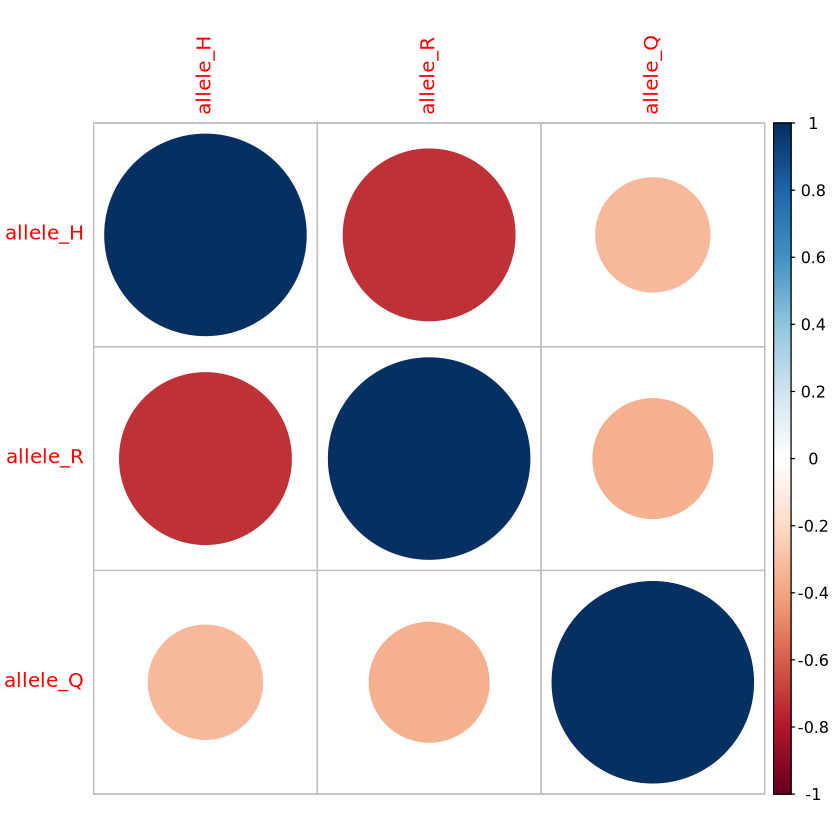

In [64]:
corrplot(cor_list[[1]], method = "circle")

### Script for the POWER analysis

In [ ]:
hla_features <- read_tsv('../hla_features_wo_duplicates.tsv')
patients_ids <- unlist(read.table('../patients_ids_wo_duplicates.txt', header = FALSE)$V1)
n_ids <- length(patients_ids)
hla_gene = c('A', 'B', 'C', 'DPA1', 'DPB1', 'DQA1', 'DQB1','DRB1')


manova_template <- read_tsv('../mmlm_results_2/DRB1_233_12_P108_sample_size_10_replicate_1.tsv')[0,]

for (n in c(1000, 1400, 800,n_ids, 400,600, 200)){
    dir_hla_path <- paste0('../hla_matrices/all_variable')
    dir_pair_path <- paste0('../cdr3_hla_pairs//',n,'/')
    dir_results <- paste0('../mmlm_results_2/',n,'/')
    
    # creating subdirectories if they don't exist
    if (!file.exists(dir_hla_path)) {
    dir.create(dir_hla_path, recursive = TRUE)
    }
    if (!file.exists(dir_pair_path)) {
    dir.create(dir_pair_path, recursive = TRUE)
    }
    if (!file.exists(dir_results)) {
    dir.create(dir_results, recursive = TRUE)
    }

    manova_df_size_pairs <- manova_template
    
    #for each downsampling creating matrices for each replicate
    for (replic in c(3,2,1)){
        sampling_ids <- sample(x = unlist(patients_ids), size  = n)
        write.table(sampling_ids, paste0('../ids_size_',n,'_rep_',replic,'.txt'), row.names = FALSE, quote = TRUE)

        for (gene_name in hla_gene){   
            hla_reference_long <- read.csv(paste0("../../reference_data/hla_msa/",gene_name, "_long.tsv"), sep = '\t')
            
            hla_patients <- hla_features %>%
                filter(gene == gene_name, patient_id %in% sampling_ids) %>% 
                inner_join(hla_reference_long, relationship = "many-to-many", by = join_by(allele)) %>%
                group_by(site, AA) %>%
                mutate(n_carriers = lengths(list(unique(patient_id)))) %>%
                filter(n_carriers >= n*0.025) %>%
                ungroup() %>%
                group_by(site) %>%
                mutate(variat = list(unique(AA)), n_variat = lengths(variat)) %>%
                filter(n_variat >= 2) %>%
                ungroup()
            hla_patients$variat_chr <- sapply(hla_patients$variat, function(x){paste0(x, collapse = '')})
            write_tsv(hla_patients, paste0('../hla/hla_variation_size_',n,'_rep',replic,'.tsv'))
           
            site_split <- hla_patients %>% select(patient_id, homo_hetero, site, AA) %>% 
                group_by(patient_id, site, AA) %>%
                summarize(homo_hetero = sum(homo_hetero), .groups = "keep") %>%
                ungroup() %>%
                group_split(site) 
            for (site in seq(1, length(site_split))){
                site_location <- site_split[[site]]$site[1]
                site_matrix <- site_split[[site]] %>% select(-site) %>% 
                    pivot_wider(names_from=AA, values_from = homo_hetero, values_fn = sum, values_fill = 0, names_prefix = 'allele_')
                site_matrix$G_S <- paste0(gene_name,':',site_location)
                write_tsv(site_matrix, paste0(dir_hla_path,gene_name, "_",site_location, "_size_",n,"_rep_",replic,".tsv"))

                # now at this step we have hla_matrix and we creating hla_cdr3_matrix and going through mmlm
                pivoted_cdr3_public <- pivoted_together_freq %>% 
                    filter(patient_id %in% sampling_ids) %>%
                    group_by(length, IMGT, AA) %>% 
                    mutate(n_carriers = length(unique(patient_id))) %>%
                    ungroup() %>%
                    arrange(n_carriers) %>%
                    filter(n_carriers >= (length(sampling_ids)/2)) %>% 
                    select(-c('total_AA_count', 'total_IMGT_count', 'n_carriers'))


                pivoted_cdr3_public_splitted_L_P <- pivoted_cdr3_public %>% group_by(length, IMGT) %>%
                    group_split()

        
                for (L_P_group in seq(1,length(pivoted_cdr3_public_splitted_L_P))){
                
                    pivoted_cdr3_L_P <- pivoted_cdr3_public_splitted_L_P[[L_P_group]]
                    L <- unique(pivoted_cdr3_public_splitted_L_P[[L_P_group]]$length)
                    P <- unique(pivoted_cdr3_public_splitted_L_P[[L_P_group]]$IMGT)
                    
                        
                    pivoted_cdr3_matrix <- cdr3_matrix(pivoted_cdr3_L_P)
                    pivoted_cdr3_matrix$L_P <- paste0(L,':',P)
                  
                    name_pair <- paste0(gene_name,'_',site_location,'_',L,'_',P)
                    cdr3_hla_matrix <- site_matrix %>%
                        inner_join(pivoted_cdr3_matrix, by='patient_id')
                    write_tsv(cdr3_hla_matrix, paste0('../cdr3_hla_pairs/',n,'/',name_pair,'_matrix_size_',n,'_rep',replic,'.tsv'))
        
                    manova_results <- mlm_fun(cdr3_hla_matrix_pca, dir_results, sample_size = n, replic = replic)
                    manova_df <- manova_results %>% mutate(pair = name_pair, size = n, replic = replic)
                    manova_df_size_pairs <- bind_rows(manova_df_size_pairs, manova_df)
                }
            }
        }
    }
    write_tsv(manova_df_size_pairs, paste0('../manova_results_size_',n,'.tsv'))
}


Rows: 21904 Columns: 4
── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): gene, allele
dbl (2): patient_id, homo_hetero

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2 Columns: 14
── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (2): pair, model
dbl (12): Res.Df, Df, Gen.var., Pillai, approx.F, num.Df, den.Df, Pr..F., re...

ℹ Use `spec()` to retrieve the full column specification for this data

### DOWNSAMPLING of CDR3

## Annotations of genes and visualisation: all variable sites and highly variable - present in a side-to-side way for comparison

### put all variable and highly variable in one df

In [20]:
n_tests <- length(list.files('../cdr3_hla_pairs/all_variable_sites/')) * 12 # because on average we have 12 amino acids in the matrix 
bonf <- 0.05/n_tests
manova_df_all <- read_tsv('../manova_results_all_variable_sites.tsv') %>% 
    separate(pair, into = c('gene', 'site', 'length', 'position'), sep = ':', remove = FALSE) %>% 
    mutate(site = as.numeric(site), length = as.numeric(length),
           significance = ifelse(Pr..F. <= bonf, 'yes', 'no'),
           batch = 'all_variable_sites')

n_tests_high <- length(list.files('../cdr3_hla_pairs/highly_variable_sites/')) * 12 # because on average we have 12 amino acids in the matrix 
bonf_high <- 0.05/n_tests_high
manova_df_high <- read_tsv('../manova_results.tsv') %>% 
    separate(pair, into = c('gene', 'site', 'length', 'position'), sep = ':', remove = FALSE) %>% 
    mutate(site = as.numeric(site), length = as.numeric(length),
           significance = ifelse(Pr..F. <= bonf_high, 'yes', 'no'),
           batch = 'highly_variable_sites')

manova_df_both <- bind_rows(manova_df_all, manova_df_high) 

Rows: 34844 Columns: 13
── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (2): pair, model
dbl (11): Res.Df, Df, Gen.var., Pillai, approx.F, num.Df, den.Df, Pr..F., Om...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 6572 Columns: 14
── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (2): pair, model
dbl (11): Res.Df, Df, Gen.var., Pillai, approx.F, num.Df, den.Df, Pr..F., Om...
lgl  (1): var_expl



In [3]:
hla_annotations <- read.csv('../../reference_data//hla_annotations.csv', sep =';')

### Visualisation of MANOVA in gene-wise manner

In [49]:
hla_interest <- manova_df_both %>% filter(gene == 'B') 

hla_interest_sites_of_interest <- hla_interest %>% filter(significance == 'yes') %>% filter(site %in% c(9,156,97, 325)) %>% 
    mutate(highlighed_cdr3_positions = ifelse(position %in% c('P109','P110', 'P114', 'P115', 'P113'), position, NA))

In [50]:
hla_interest_sites_of_interest %>% arrange(Pr..F.)

Res.Df Df Gen.var.  Pillai     approx.F num.Df den.Df Pr..F.      
1   1954   3  0.8602092 0.15266420 5.184716 60     5802   2.045449e-34
2   1954   3  0.8602092 0.15266420 5.184716 60     5802   2.045449e-34
3   1954   2  0.8470741 0.10408238 5.308651 40     3868   1.607124e-24
4   1954   2  0.8470741 0.10408238 5.308651 40     3868   1.607124e-24
5   1953   2  0.8597441 0.09868252 5.283095 38     3868   2.820027e-23
6   1953   2  0.8597441 0.09868252 5.283095 38     3868   2.820027e-23
7   1949   2  0.8442737 0.10043723 5.099685 40     3858   4.164979e-23
8   1949   2  0.8442737 0.10043723 5.099685 40     3858   4.164979e-23
9   1954   3  0.8470741 0.11462985 3.841693 60     5802   2.853873e-21
10  1954   3  0.8470741 0.11462985 3.841693 60     5802   2.853873e-21
11  1954   3  0.8322340 0.11383579 3.814031 60     5802   5.195045e-21
12  1954   3  0.8322340 0.11383579 3.814031 60     5802   5.195045e-21
13  1954   1  0.8470741 0.07049424 7.333783 20     1934   2.080891e-20
14  1954   2  0.8602092 0.09184700 4.654556 40     3868   3.893097e-20
15  1954   2  0.8602092 0.09184700 4.654556 40     3868   3.893097e-20
16  1953   5  0.8439058 0.13972176 2.926212 95     9670   1.826687e-19
17  1947   3  0.8354072 0.10505226 3.682291 57     5784   6.472887e-19
18  1947   3  0.8354072 0.10505226 3.682291 57     5784   6.472887e-19
19  1947   5  0.8354072 0.13679652 2.854342 95     9640   1.665059e-18
20  1952   3  0.8685073 0.10505495 3.505527 60     5796   3.784932e-18
21  1952   3  0.8685073 0.10505495 3.505527 60     5796   3.784932e-18
22  1924   2  0.8357949 0.08246376 4.311823 38     3810   4.121307e-17
23  1930   2  0.8463180 0.08184645 4.291642 38     3822   5.479370e-17
24  1947   3  0.8390747 0.09903378 3.289216 60     5781   3.444906e-16
25  1947   3  0.8390747 0.09903378 3.289216 60     5781   3.444906e-16
26  1953   2  0.8586549 0.08018210 4.036633 40     3866   4.157218e-16
27  1953   2  0.8586549 0.08018210 4.036633 40     3866   4.157218e-16
28  1952   5  0.8311743 0.12732571 2.658441 95     9665   5.937544e-16
29  1953   2  0.8439058 0.07776225 4.117794 38     3868   6.394065e-16
30  1953   2  0.8439058 0.07776225 4.117794 38     3868   6.394065e-16
⋮   ⋮      ⋮  ⋮         ⋮          ⋮        ⋮      ⋮      ⋮           
97  1950   5  0.8763806 0.09688841 2.008301  95    9655   2.712232e-08
98  1947   2  0.8390747 0.05506065 2.727639  40    3854   3.497194e-08
99  1947   2  0.8390747 0.05506065 2.727639  40    3854   3.497194e-08
100 1927   2  0.8776491 0.05386317 2.779350  38    3816   3.802662e-08
101 1930   2  0.8529990 0.05505693 2.703389  40    3820   4.786736e-08
102 1943   5  0.8401425 0.09561105 1.974125  95    9620   6.192800e-08
103 1925   2  0.8303883 0.05313939 2.738111  38    3812   6.321359e-08
104 1950   3  0.8685847 0.06966123 2.294038  60    5790   6.423636e-08
105 1950   3  0.8685847 0.06966123 2.294038  60    5790   6.423636e-08
106 1947   3  0.8295808 0.06748388 2.335141  57    5784   6.515247e-08
107 1947   3  0.8295808 0.06748388 2.335141  57    5784   6.515247e-08
108 1952   2  0.8311743 0.05226590 2.730028  38    3866   6.951703e-08
109 1952   2  0.8311743 0.05226590 2.730028  38    3866   6.951703e-08
110 1944   5  0.8450542 0.09855613 1.934348 100    9620   8.001469e-08
111 1953   2  0.8537581 0.05302788 2.632367  40    3866   1.177197e-07
112 1953   2  0.8537581 0.05302788 2.632367  40    3866   1.177197e-07
113 1952   5  0.8685073 0.09717036 1.914539 100    9660   1.300235e-07
114 1952   3  0.8241153 0.06832669 2.251396  60    5796   1.333970e-07
115 1952   3  0.8241153 0.06832669 2.251396  60    5796   1.333970e-07
116 1954   2  0.8322340 0.05274008 2.619047  40    3868   1.392559e-07
117 1954   2  0.8322340 0.05274008 2.619047  40    3868   1.392559e-07
118 1954   3  0.8563843 0.06560156 2.276787  57    5805   1.704257e-07
119 1954   3  0.8563843 0.06560156 2.276787  57    5805   1.704257e-07
120 1931   2  0.8561596 0.05078675 2.621955  38    3824   2.590544e-07
121 1931   2  0.8480457 0.05

Warning message:
“Removed 3410 rows containing missing values or values outside the scale range (`geom_point()`).”


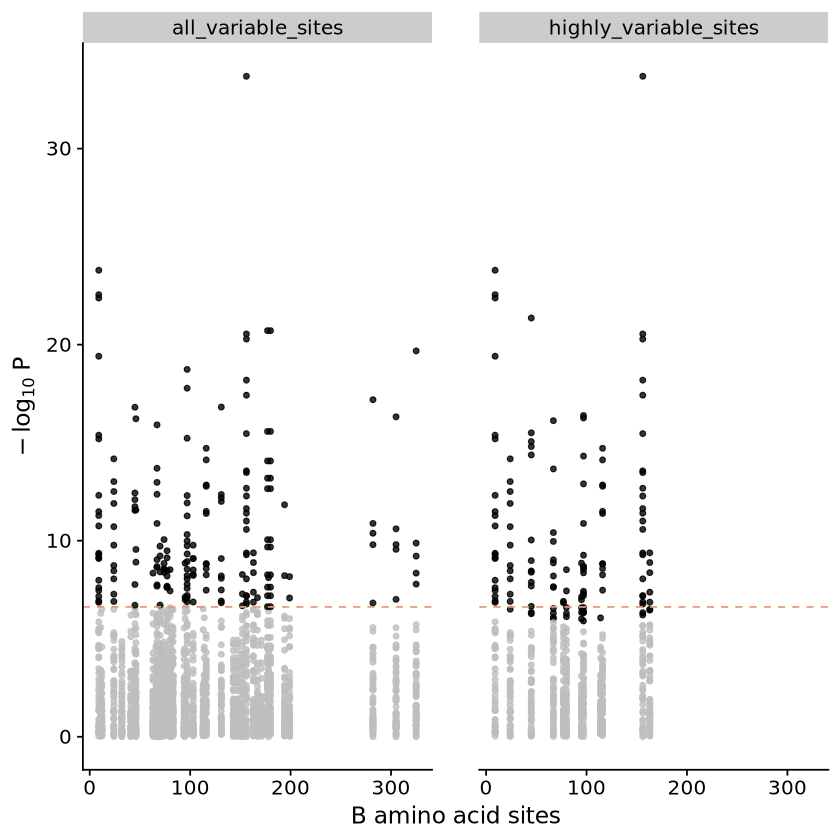

In [40]:
ggplot() + 
    geom_point(data = hla_interest, aes(x = site, y = -log10(Pr..F.), color = significance), show.legend = FALSE, alpha=0.8, size=1.3) +
    scale_color_manual(values = c('yes' = 'black', 'no' = 'grey')) +
    labs(x = "B amino acid sites", y = expression(paste(-log[10], " ", P))) +
    geom_hline(yintercept= - log10(bonf), linetype="dashed", color = "darksalmon") +
    facet_wrap(~batch) +
    theme_cowplot() +
    theme(panel.spacing = unit(1, "cm"))

Warning message:
“Removed 3410 rows containing missing values or values outside the scale range (`geom_point()`).”
Warning message:
“Removed 49 rows containing missing values or values outside the scale range (`geom_point()`).”
Warning message:
“Removed 3410 rows containing missing values or values outside the scale range (`geom_point()`).”
Warning message:
“Removed 49 rows containing missing values or values outside the scale range (`geom_point()`).”


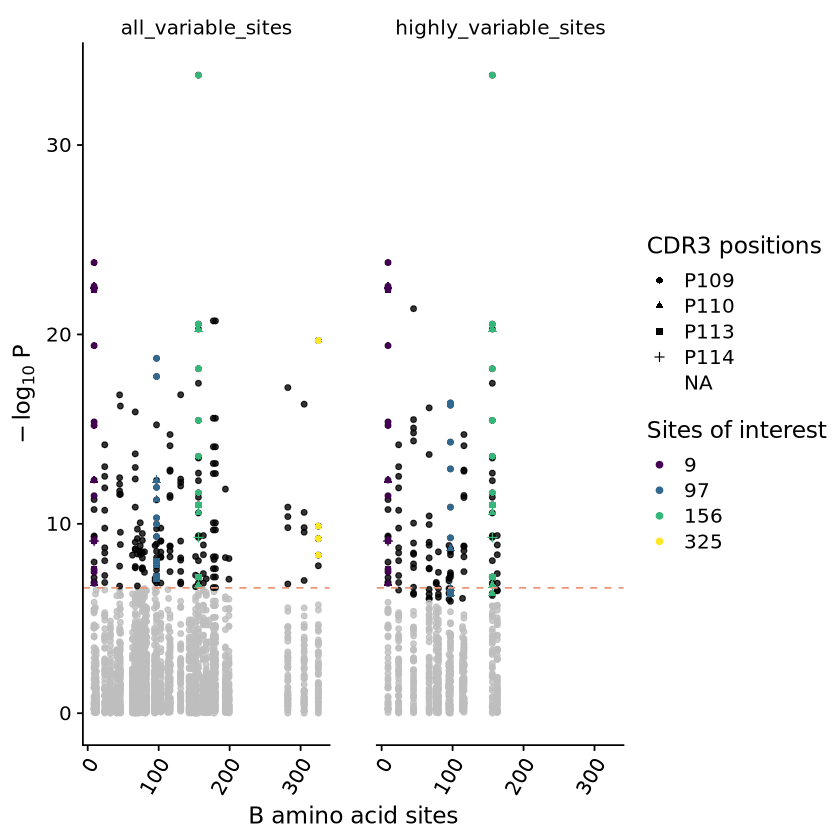

In [54]:
pl_hla_manh <- ggplot() + 
    geom_point(data = hla_interest, aes(x = site, y = -log10(Pr..F.), color = significance), alpha=0.8, size=1.3) +
    scale_color_manual(values = c('yes' = 'black', 'no' = 'grey')) +
    guides(color = "none") +
    labs(x = "B amino acid sites", y = expression(paste(-log[10], " ", P))) + 
    new_scale_color() + 
    geom_point(data = hla_interest_sites_of_interest, aes(x=site, y = -log10(Pr..F.), color = factor(site), shape = factor(highlighed_cdr3_positions))) +
    labs(color = "Sites of interest", shape = "CDR3 positions") +
    #scale_color_manual(values = c('13' = 'deeppink3')) +
    #geom_point(data = drb1_ref %>% filter(feature %in% c('Antigen_binding', 'Glycosylation', 'Phosphoserine')), 
              #aes(x = start, y = -1, shape = feature)) +
    #scale_shape_manual(values = ifelse("Antigen_binding" = 13, 'no' = 23) , guide = "none" , drop = FALSE, na.translate = TRUE) +
    scale_color_viridis_d() +
    geom_hline(yintercept= - log10(bonf), linetype="dashed", color = "darksalmon") +
    theme(legend = 'none') +
    theme_cowplot() +
    theme(axis.text.x = element_text(angle = 60, hjust = 1), strip.background = element_rect(fill = "white")) +
    new_scale_color() + 
    #geom_segment(aes(x = 13, xend = 87, y=-1, yend = -1, colour = 'Beta domain')) +
    #geom_segment(aes(x = 97, xend = 185, y=-1, yend = -1, colour = 'Ig-like C1 type domain')) +
    #scale_color_manual(values = c('Beta domain' = 'deeppink3', 'Ig-like C1 type domain' = 'brown1')) +
    #theme(legend.position = "bottom", legend.text = 'CDR3 position') +
    facet_wrap(~batch) +
    theme(panel.spacing = unit(1, "cm"))
    
    
    

pl_hla_manh
               
ggsave('../plots/B.jpg',pl_hla_manh, width = 10, height = 4)

### Visualisation of variance explained

In [ ]:
pl <- ggplot(manova_df_all) +
    geom_point(aes(x = site, y = -log10(Pr..F.), color=as.factor(gene)), alpha=0.8, size=1.3, show.legend = FALSE) +
    scale_color_viridis_d() +
    scale_x_continuous(breaks = as.integer(seq(0, 300, length.out = 5))) +
    labs(x = "HLA amino acid site", y = expression(paste(-log[10], " ", P))) +
    geom_hline(yintercept= - log10(bonf), linetype="dashed", color = "red") +
    theme(legend.position = "none") +
    theme_cowplot() +
    facet_grid(~gene, space = "free") +
    theme(axis.text.x = element_text(angle = 60, hjust = 1), strip.background = element_rect(fill = "white")) #+
    #geom_segment(data = hla_annotation, aes(x = start, xend = end, y=-0.01, yend=-0.01), color = 'blue', label = NA)
pl
ggsave('../data/TRB_samples/plots/trb_manova_annotated.jpg',pl, width = 10, height = 4)


## Preparing CDR3_HLA matrices for Hurdle models

### CDR3_HLA matrices with unique_counts

In [114]:
source('R_scripts/cdr3-hla-matrices-oktober.r')

### Plots of AA dist in one long .pdf

In [ ]:

library(ggplot2)

pdf("ggplot_plots.pdf", width = 7, height = 5)

# Create first ggplot
ggplot(data, aes(x, y)) + geom_point() + ggtitle("First Plot")

# Create second ggplot
ggplot(data, aes(a, b)) + geom_line() + ggtitle("Second Plot")

# Continue adding ggplot plots...

dev.off()


### Visualising the distributions for each Length-IMGT combinations with different measures

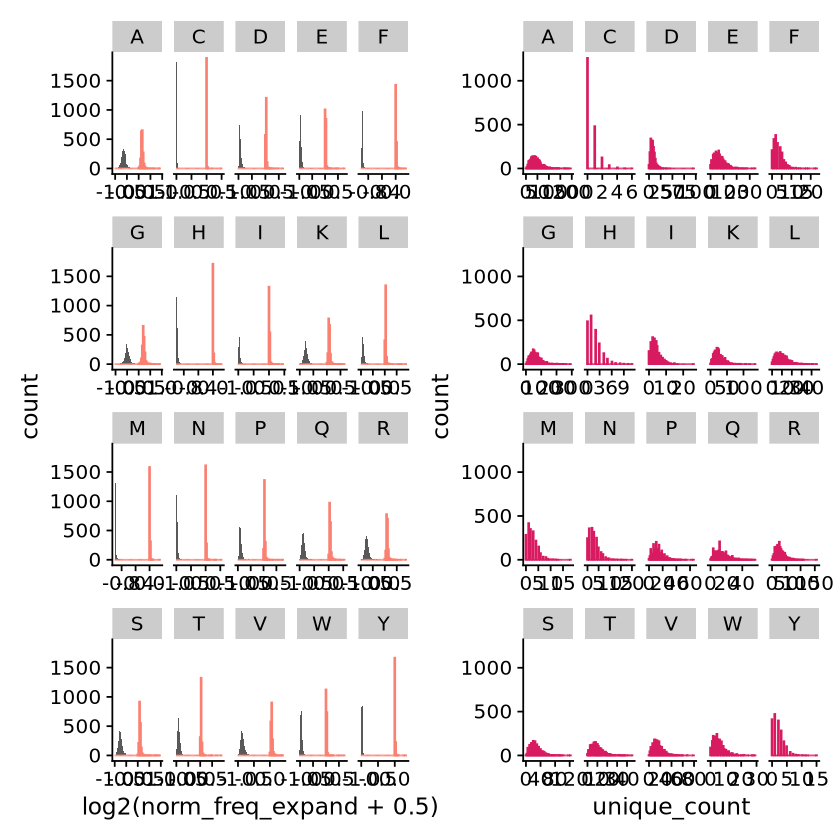

In [117]:
imgt_l <- fread('../cdr3_hla_pairs/CDR3_GROUPS_FREQ/16_P115.tsv')
imgt_l_counts <- fread('../cdr3_hla_pairs/CDR3_GROUPS_UNIQUE_COUNT/16_P115.tsv')

ggplot() +
geom_histogram(data = imgt_l, aes(log2(norm_freq_expand+ 0.5) ), bins = 50) +
new_scale_color() + 
geom_histogram(data = imgt_l, aes(norm_freq_expand), color = 'salmon', alpha = 0.5, bins = 50)+
theme_cowplot() +
facet_wrap(~AA, scale = 'free_x') |

ggplot() +
geom_histogram(data = imgt_l_counts, aes(unique_count), color = '#D81B60', alpha = 0.5, bins = 50) +
theme_cowplot() +
facet_wrap(~AA, scale = 'free_x')

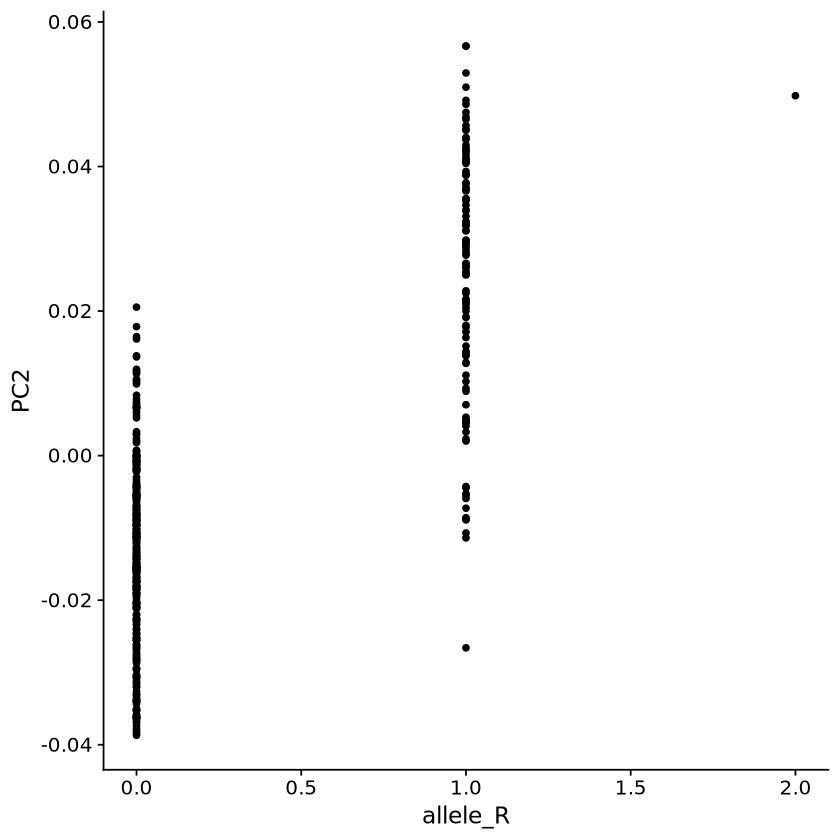

In [299]:
ggplot() +
geom_point(data = validation, aes(x = allele_R, y = PC2)) +
theme_cowplot() 

In [301]:
cor(validation$allele_R, validation$PC2)

[1] 0.7778084

In [280]:
length(drb1_13[allele_R == 2]$V)

[1] 18

In [ ]:
cdr3_freq <- fread('../data/cdr3_all_freq_with_IRT.tsv')
cdr3_freq <- cdr3_freq[(total_imgt_count > 20 & n_carriers > 200)]
cdr3_freq_split_l_imgt <- split(cdr3_freq, by = c('length_seq', 'IMGT'))

dir_pair_path <- paste0('../cdr3_hla_pairs/')
hla_matrices <- paste0('../hla_matrices_v3/with_pcs/',list.files('../hla_matrices_v3/with_pcs/'))

for (L_P_group in seq(1,length(cdr3_freq_split_l_imgt))){

    cdr3_L_P <- cdr3_freq_split_l_imgt[[L_P_group]]
   
    L <- unique(cdr3_L_P$length_seq)
    P <- unique(cdr3_L_P$IMGT)
        
    #-----cdr3_matrix_fun() takes the l_imgt group, filters AA with at least 'threshold' carriers, and the name of measurment for widening into matrix
    cdr3_group_long <- cdr3_prep_for_count_matrix_fun(cdr3_L_P)    
    
    path_group <- '../cdr3_hla_pairs/CDR3_GROUPS_UNIQUE_COUNT/'
    fwrite(cdr3_group_long, paste0(path_group,L,'_',P,'.tsv'), sep = '\t')
    
    prep_modes <- c('norm_freq_expand', 'norm_freq_unique', 'log_c_freq_expand', 'log_c_freq_unique', 'binary_state' )
    for (prep_mode in prep_modes){
        cdr3_matrix <- dcast(cdr3_group_long, patient_id ~ AA, value.var = prep_mode)
            
        for (f in hla_matrices){
            
            hla_matrix <- fread(f)
            
            cdr3_hla_matrix <- merge(hla_matrix, cdr3_matrix, by = 'patient_id', all.x = TRUE)
            cdr3_hla_matrix$pair <- paste0(hla_matrix$G_S[1],'_', L, '_', P)
            name_pair <- cdr3_hla_matrix$pair[1]
    
            path_out <- paste0(dir_pair_path,prep_mode, '/')
            if (!file.exists(path_out)) {
                dir.create(path_out, recursive = TRUE)
                }
            cdr3_hla_matrix[, G_S := NULL]
            fwrite(cdr3_hla_matrix, paste0(path_out,name_pair,'_matrix.tsv'), sep = '\t')
            
        }
        }

    
}

## Hurdle models for all 1922 individuals with lots of zeros

In [96]:
source('cdr3-QTL_functions.R')

In [118]:
cdr3_hla_matrix <- fread('../cdr3_hla_pairs/unique_count/A_149_16_P115_matrix.tsv')

In [119]:
cdr3_hla_matrix

patient_id allele_A allele_T PC1           PC2           PC3          
1    H0         2        0        -0.021016008   0.0311255330  0.0116928036
2    H1         2        0        -0.026263661   0.0278257381 -0.0137243686
3    H10        2        0        -0.021112345  -0.0139657642  0.0131939916
4    H100       1        1        -0.013163776  -0.0133461565  0.0116567083
5    H101       2        0        -0.023786622   0.0322201904  0.0104573224
6    H102       2        0        -0.023127366  -0.0241120489  0.0230398584
7    H103       1        1        -0.018172440  -0.0082898041 -0.0474353444
8    H104       2        0        -0.026083952  -0.0320901066  0.0398264007
9    H105       2        0        -0.020987288  -0.0054826249  0.0141241542
10   H106       2        0        -0.020907416  -0.0189226394 -0.0108389480
11   H107       1        0        -0.007995394  -0.0095253625 -0.0344945064
12   H108       1        1        -0.017571312  -0.0096027118 -0.0203181775
13   H109       2        0        -0.017769664   0.0027413972 -0.0163012043
14   H11        2        0        -0.023007863  -0.0101722067 -0.0338248467
15   H110       2        0        -0.015711687  -0.0153850688 -0.0361277734
16   H111       2        0        -0.013990856  -0.0100798430 -0.0007511819
17   H112       2        0        -0.022152004  -0.0239540353  0.0271366660
18   H113       2        0        -0.026904740  -0.0182122183  0.0370811060
19   H114       2        0        -0.030293018   0.0335483633 -0.0122960969
20   H115       1        1        -0.022038257  -0.0050769799 -0.0370505308
21   H116       2        0        -0.024300395  -0.0186090559 -0.0327068572
22   H117       2        0        -0.013613465   0.0063851540 -0.0037522786
23   H118       2        0        -0.026270735   0.0268295818  0.0286229376
24   H119       2        0        -0.012320276  -0.0040313073 -0.0024595487
25   H12        2        0        -0.024236005   0.0001096752 -0.0393156729
26   H120       2        0        -0.019847774  -0.0143457598 -0.0216762461
27   H121       2        0        -0.022937458   0.0070566507 -0.0165507959
28   H122       2        0        -0.020931744   0.0106759510 -0.0025804195
29   H123       2        0        -0.022926784  -0.0392537684  0.0097664905
30   H124       2        0        -0.026767618   0.0448973345  0.0089432846
⋮    ⋮          ⋮        ⋮        ⋮             ⋮             ⋮            
1893 I970       2        0        -0.0266131281 -0.0289388112  0.0322022815
1894 I972       1        0        -0.0210297008  0.0449307712  0.0102055902
1895 I973       2        0        -0.0205199040 -0.0164403207  0.0080826829
1896 I974       2        0        -0.0269510922  0.0202204876  0.0199305527
1897 I975       1        0        -0.0167192306  0.0137498109  0.0121370500
1898 I976       1        0        -0.0250402599 -0.0205201248 -0.0117921878
1899 I977       2        0        -0.0155562125 -0.0210378943 -0.0191719800
1900 I978       1        0        -0.0290455068 -0.0363189687  0.0452728791
1901 I979       1        1        -0.0210120273  0.0350163123  0.0013538754
1902 I98        2        0        -0.0223642606 -0.0147132788 -0.0445045552
1903 I980       2        0        -0.0230226164  0.0183338247 -0.0222516766
1904 I982       1        1        -0.0166046344 -0.0178868644 -0.0272628868
1905 I983       2        0        -0.0166463423 -0.0303552567  0.0376596641
1906 I984       2        0        -0.0231847764 -0.0128085126  0.0068789511
1907 I985       1        1        -0.0225646113 -0.0025181191 -0.0390582414
1908 I986       1        0        -0.0241550180 -0.0119737004  0.0047711429
1909 I987       2        0        -0.0211835471 -0.0079491825 -0.0248137862
1910 I988       2        0        -0.0240791266 -0.0059508583  0.0002184919
1911 I989       1        1        -0.0119367036  0.0111251678  0.0001269675
1912 I99        2        0        -0.0206573545  0.0017990905 -0.0147729734
1913 I990       1        0        -0.0002320689  0.00

In [122]:
cdr3_hla_matrix <- setting_allele_reference(cdr3_hla_matrix)

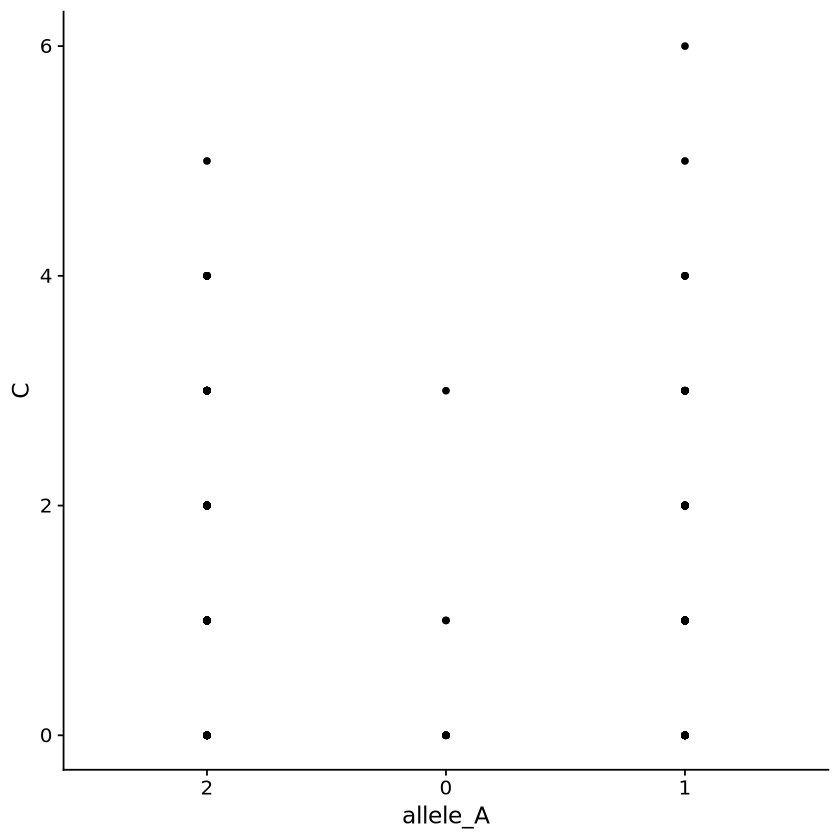

In [124]:
ggplot() +
geom_point(data = cdr3_hla_matrix, aes(x = allele_A, y = C)) + 
theme_cowplot()


In [139]:
# Fit the full hurdle model
full_model <- hurdle(C ~ allele_A + allele_T + PC1 + PC2 + PC3 + PC4 + PC5, data = cdr3_hla_matrix, dist = "poisson")

# Fit the null model (no predictors, just intercept)
null_model <- hurdle(C ~ PC1 + PC2 + PC3 + PC4 + PC5, data = cdr3_hla_matrix, dist = "poisson")

# Compare the models using anova
logLik_model1 <- logLik(full_model)
logLik_model2 <- logLik(null_model)

# Perform the likelihood ratio test manually
LRT_stat <- 2 * (logLik_model2 - logLik_model1)
df <- attr(logLik_model1, "df") - attr(logLik_model2, "df")

# Calculate the p-value
p_value <- pchisq(LRT_stat, df = df, lower.tail = FALSE)

# Print the results
cat("Likelihood Ratio Test Statistic:", LRT_stat, "\n")
cat("Degrees of Freedom:", df, "\n")
cat("P-value:", p_value, "\n")


Likelihood Ratio Test Statistic: -18.36545 
Degrees of Freedom: 18 
P-value: 1 


In [137]:
df

[1] 8

In [138]:
BIC(null_model, full_model)

df BIC     
null_model 12 3646.712
full_model 20 3694.723

### Applying parallelisation

In [147]:
library(future.apply)

In [141]:
plan(multicore)

In [150]:
source('cdr3-QTL_functions.R')

In [152]:
matrices_path <- '../cdr3_hla_pairs/irt_freq_expand/'
dir_results <- '../LM_IRT_EXPAND/'

cdr3_hla_files <- paste0(matrices_path, list.files(matrices_path))

# Run the model fitting in parallel

model_list <- future_lapply(cdr3_hla_files[1:3], function(cdr3_hla_file) {
    mlm_fun(cdr3_hla_file, dir_results, 3)
})

Warning message in CompQuadForm::davies(0, lambda = gamma, h = nu, lim = lim, acc = acc):
“Consider playing with 'lim' or 'acc'.”
Warning message in CompQuadForm::davies(0, lambda = gamma, h = nu, lim = lim, acc = acc):
“Consider playing with 'lim' or 'acc'.”
Warning message in CompQuadForm::davies(0, lambda = gamma, h = nu, lim = lim, acc = acc):
“Consider playing with 'lim' or 'acc'.”
Warning message in CompQuadForm::davies(0, lambda = gamma, h = nu, lim = lim, acc = acc):
“Consider playing with 'lim' or 'acc'.”
Warning message in CompQuadForm::davies(0, lambda = gamma, h = nu, lim = lim, acc = acc):
“Consider playing with 'lim' or 'acc'.”
Warning message in CompQuadForm::davies(0, lambda = gamma, h = nu, lim = lim, acc = acc):
“Consider playing with 'lim' or 'acc'.”
Warning message in CompQuadForm::davies(0, lambda = gamma, h = nu, lim = lim, acc = acc):
“Consider playing with 'lim' or 'acc'.”
Warning message in CompQuadForm::davies(0, lambda = gamma, h = nu, lim = lim, acc = acc):


In [149]:
model_list

ERROR: Error in eval(expr, envir, enclos): object 'model_list' not found


In [237]:
drb1_13 <- fread('../cdr3_hla_pairs/irt_freq_unique/DRB1_13_13_P109_matrix.tsv')

In [238]:
dim(drb1_13)
head(drb1_13)

[1] 1922   39

patient_id allele_F allele_G allele_H allele_R allele_S allele_Y PC1        
1 H0         0        0        0        1        0        0        -0.02101601
2 H1         0        0        0        1        0        1        -0.02626366
3 H10        0        0        0        0        2        0        -0.02111234
4 H100       0        0        0        0        1        0        -0.01316378
5 H101       0        0        0        1        1        0        -0.02378662
6 H102       0        1        0        0        1        0        -0.02312737
  PC2         PC3         ⋯ P          Q           R           S         
1  0.03112553  0.01169280 ⋯  0.4181212 -0.44820363 -0.06329482 -0.3982762
2  0.02782574 -0.01372437 ⋯ -0.4181212 -0.07636852  0.66144861  0.1948972
3 -0.01396576  0.01319399 ⋯  1.0770059 -0.29846459 -0.60252275  0.8639469
4 -0.01334616  0.01165671 ⋯ -0.2497127  0.16044745  0.50519267  0.6198147
5  0.03222019  0.01045732 ⋯  0.5395751  0.52754557  0.64691044 -1.2125912
6 -0.02411205  0.02303986 ⋯  1.2836296 -0.14725032 -1.80369001  0.9649949
  T           V          W          Y          L_P     pair           
1 -0.03456757  2.2032740 -0.6926112 -2.0639564 13_P109 DRB1_13_13_P109
2  0.98175069  0.3856014 -0.7025919 -0.2349391 13_P109 DRB1_13_13_P109
3 -0.95260382 -1.8975731  0.1975562 -1.3422945 13_P109 DRB1_13_13_P109
4 -1.49560943  0.2524045  1.2925988 -0.5577676 13_P109 DRB1_13_13_P109
5  0.16441194  0.9242446 -0.0397879 -1.0539988 13_P109 DRB1_13_13_P109
6 -0.79764239 -0.5320476 -0.2902930 -1.7529850 13_P109 DRB1_13_13_P109

In [253]:
as.formula(str_c(Y,PCs))

cbind(A, C, D, E, F, G, H, I, K, L, M, N, P, Q, R, S, T, V, W, 
    Y) ~ PC1

In [303]:
n_pcs = 9
#cdr3_hla_matrix <- setting_allele_reference(cdr3_hla_matrix)
cdr3_hla_matrix <- drb1_13[sample(.N, 1500)]
validation <- setdiff(drb1_13, cdr3_hla_matrix)
bonf <- 0.01/40000
amino_acids <-c('A','C','D','E','F','G','H','I','K','L','M','N','P','Q','R','S','T','V','W','Y') 
name_pair <- unique(cdr3_hla_matrix$pair)

hla_alleles <- cdr3_hla_matrix %>% summarise(across(contains('allele'), sum)) %>% t() %>% as.data.frame() %>% arrange(desc(V1)) %>% slice(-1) %>% rownames()
aa_in_matrix <- paste0(colnames(cdr3_hla_matrix)[colnames(cdr3_hla_matrix) %in% amino_acids], collapse = ',')
Y <- paste0('cbind(',aa_in_matrix,') ~')
X <- paste0(hla_alleles, collapse = '+')
PCs <- paste0('PC', seq(1,n_pcs), collapse = '+')

formula_full <- as.formula(str_c(paste0(Y,X),PCs, sep   = '+'))
formula_null <- as.formula(str_c(Y,PCs))
    
mod1 <- lm(formula_full, data = cdr3_hla_matrix)
mod0 <- lm(formula_null, data = cdr3_hla_matrix)
mod1_summary <- summary(mod1)
mod0_summary <- summary(mod0)

dir_results_summary <- paste0(dir_results,'/mmlm_summary/')
if (!file.exists(dir_results_summary)) {
    dir.create(dir_results_summary, recursive = TRUE)
    }

manova_results <- anova(mod1, mod0)
manova_df <- as.data.table(manova_results)
manova_df[, pair := name_pair]


allele_to_exclude <- rownames(coef(mod1))[is.na(rowSums(coef(mod1)))]
new_hla_alleles <- setdiff(hla_alleles, allele_to_exclude)
X <- paste0(new_hla_alleles, collapse = '+')

#if (nchar(X)!= 0){
    #formula_full <- as.formula(str_c(paste0(Y,X),'+', PCs)) 
    
#} else{
   # formula_full <- as.formula(str_c(paste0(Y,X),PCs))
#}

predictions_full <- predict(mod1, newdata = validation)
predictions_null <- predict(mod0, newdata = validation)

In [304]:
mod1_summary

Response A :

Call:
lm(formula = A ~ allele_R + allele_H + allele_F + allele_Y + 
    allele_G + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + 
    PC9, data = cdr3_hla_matrix)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.8356 -0.6409 -0.0103  0.6338  3.4144 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.06811    0.18372  -0.371  0.71089    
allele_R     0.34037    0.11747   2.897  0.00382 ** 
allele_H     0.09592    0.15747   0.609  0.54255    
allele_F     0.48604    0.12147   4.001 6.61e-05 ***
allele_Y    -0.19322    0.20182  -0.957  0.33852    
allele_G     0.05316    0.08408   0.632  0.52727    
PC1          6.36132    7.35893   0.864  0.38749    
PC2          2.94739    2.58016   1.142  0.25350    
PC3          1.28410    3.30785   0.388  0.69793    
PC4         -5.59562    2.24414  -2.493  0.01276 *  
PC5          4.80999    2.19091   2.195  0.02829 *  
PC6         -2.31103    2.62346  -0.881  0.37851    
PC7         -4.22894   

In [261]:
manova_df

Res.Df Df Gen.var.  Pillai    approx F num Df den Df Pr(>F)       
1 1494   NA 0.5850411        NA       NA NA       NA              NA
2 1490   -4 0.5688282 0.5191038 10.99083 80     5896   4.014164e-124
  pair           
1 DRB1_13_13_P109
2 DRB1_13_13_P109

In [262]:
for (aa in colnames(validation)[colnames(validation) %in% amino_acids]){
    print(aa)
    print(cor(as.data.table(predictions_full, "spearman")[[aa]], validation[[aa]]))
    print(cor(as.data.table(predictions_null, "spearman")[[aa]], validation[[aa]]))
    }


[1] "A"
[1] 0.2792876
[1] 0.3557309
[1] "C"
[1] 0.06483026
[1] 0.04035716
[1] "D"
[1] 0.3364916
[1] 0.3496675
[1] "E"
[1] 0.3716265
[1] 0.35066
[1] "F"
[1] 0.2271386
[1] 0.2092326
[1] "G"
[1] 0.1267953
[1] 0.2337445
[1] "H"
[1] 0.3367935
[1] 0.5031341
[1] "I"
[1] 0.23685
[1] 0.3075031
[1] "K"
[1] 0.7186845
[1] 0.7084686
[1] "L"
[1] 0.2410397
[1] 0.2620314
[1] "M"
[1] 0.3424137
[1] 0.3349035
[1] "N"
[1] 0.1802725
[1] 0.2234204
[1] "P"
[1] 0.2101394
[1] 0.2446608
[1] "Q"
[1] 0.6081502
[1] 0.6194043
[1] "R"
[1] 0.4938874
[1] 0.4203205
[1] "S"
[1] 0.1106464
[1] 0.1346669
[1] "T"
[1] 0.3132995
[1] 0.3465783
[1] "V"
[1] 0.3647034
[1] 0.3981923
[1] "W"
[1] 0.3340119
[1] 0.3365147
[1] "Y"
[1] 0.3499162
[1] 0.4374323


In [270]:
    mod1_mvlm <- mvlm(formula_full, cdr3_hla_matrix)
    mod0_mvlm <- mvlm(formula_null, cdr3_hla_matrix)
    
    var_exp_full <- mod1_mvlm$pseudo.rsq["Omnibus Effect",1]
    p_val_full <- mod1_mvlm$pv["Omnibus Effect",1]
    
    var_exp_null <- mod0_mvlm$pseudo.rsq["Omnibus Effect",1]
    p_val_null <- mod0_mvlm$pv["Omnibus Effect",1]
    
    variance_explained <- var_exp_full - var_exp_null
    names(variance_explained) <- 'var_expl'
    P_val <-  mapply(c, p_val_null, p_val_full)
    colnames(P_val) <- 'P_val'
    Omnibus = mapply(c, var_exp_null, var_exp_full)
    colnames(Omnibus) <- 'Omnibus'

In [269]:
formula_full

cbind(A, C, D, E, F, G, H, I, K, L, M, N, P, Q, R, S, T, V, W, 
    Y) ~ allele_R + allele_F + allele_H + allele_Y + allele_G

In [271]:
var_exp_full
var_exp_null

Omnibus Effect 
     0.1292722

Omnibus Effect 
     0.1578024

In [153]:
    
    

    mvlm_df <- as.data.table(Omnibus, model = c('null', 'full'),P_val, variance_explained)
    
    mod1_mvlm_summary <- summary(mod1_mvlm)
    mod0_mvlm_summary <- summary(mod0_mvlm)
    
    dir_results_summary_mvlm <- paste0(dir_results,'/mvlm_summary/')
    if (!file.exists(dir_results_summary_mvlm)) {
        dir.create(dir_results_summary_mvlm, recursive = TRUE)
        }
    
    dir_results_pairs <- paste0(dir_results,'/pair_df/')
    if (!file.exists(dir_results_pairs)) {
        dir.create(dir_results_pairs, recursive = TRUE)
        }
    
    tryCatch({
    if (na.omit(manova_df)$Pr..F. < bonf){
    
        lapply(summary(mod1), function(x){
            capture.output(x, file=paste0(dir_results_summary,name_pair,'_mod1.txt'), append = TRUE)})
        lapply(summary(mod0), function(x){
            capture.output(x, file=paste0(dir_results_summary,name_pair,'_mod0.txt'), append = TRUE)})
        lapply(summary(mod1_mvlm), function(x){
            capture.output(x, file=paste0(dir_results_summary_mvlm,name_pair,'_mod1.txt'), append = TRUE)})
        lapply(summary(mod0_mvlm), function(x){
            capture.output(x, file=paste0(dir_results_summary_mvlm,name_pair,'_mod0.txt'), append = TRUE)}) 
    } 
  
    }, 
    error = function(e) {
      # Handle the error
      message("Error: ", e)
    },
    finally = {
        manova_df <- cbind(manova_df, mvlm_df)
        return(manova_df) 
 
    })

## PCA experiment with lm()

In [4]:
source('libraries.R')


Attaching package: ‘dplyr’


The following objects are masked from ‘package:data.table’:

    between, first, last


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘tidyr’


The following object is masked from ‘package:magrittr’:

    extract


Registered S3 methods overwritten by 'ggtern':
  method           from   
  grid.draw.ggplot ggplot2
  plot.ggplot      ggplot2
  print.ggplot     ggplot2

--
Remember to cite, run citation(package = 'ggtern') for further info.
--


Attaching package: ‘ggtern’


The following objects are masked from ‘package:ggplot2’:

    aes, annotate, ggplot, ggplot_build, ggplot_gtable, ggplotGrob,
    ggsave, layer_data, theme_bw, theme_classic, theme_dark,
    theme_gray, theme_light, theme_linedraw, theme_minimal, theme_void


Loading required package: viridisLite


Attaching package: ‘arrow’


The following obje

In [3]:
plan(sequential)

In [2]:
source('hla_functions.R')

In [5]:
hla_genotypes_matrix <- fread('../data/hla/hla_genotypes_matrix_wo_low_ab.csv')

In [6]:
hla_random <- fread('../data/hla/hla_genotypes_random.csv')

In [7]:
pca_matrix_list <- paste0('../PCA_experiment/', list.files('../PCA_experiment/'))

In [8]:
cdr3_hla_matrix <- fread('../cdr3_hla_pairs/irt_freq_unique/DRB1_13_13_P109_matrix.tsv')
cdr3_hla_matrix <- cdr3_hla_matrix[, !grep("PC", colnames(cdr3_hla_matrix)), with = FALSE]

In [9]:
cdr3_hla_matrix_long <- fread('../cdr3_hla_pairs/CDR3_GROUPS_IRT/13_P109.tsv')

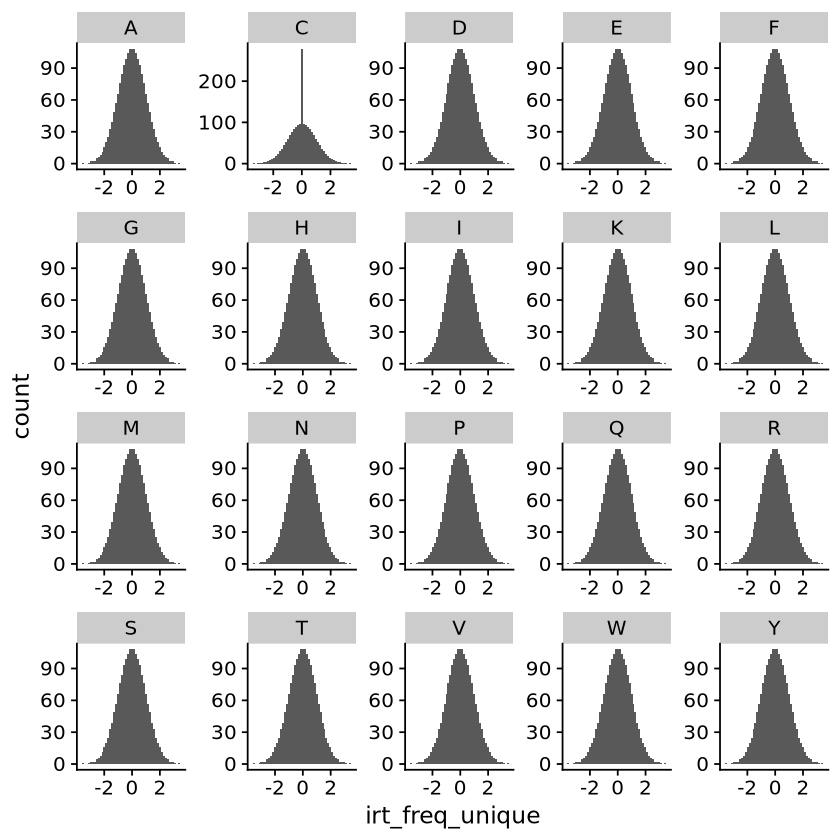

In [136]:
ggplot(cdr3_hla_matrix_long, aes(irt_freq_unique)) +
geom_histogram(bins = 50) +
theme_cowplot() +
facet_wrap(~AA, scales = 'free')

In [10]:
train <- cdr3_hla_matrix[sample(.N, 1500)]
validation <- setdiff(cdr3_hla_matrix, train)

### Comparing predictions from different models

In [11]:
amino_acids <-c('A','C','D','E','F','G','H','I','K','L','M','N','P','Q','R','S','T','V','W','Y') 
hla_alleles <- train %>% summarise(across(contains('allele'), sum)) %>% t() %>% as.data.frame() %>% arrange(desc(V1)) %>% slice(-1) %>% rownames()
aa_in_matrix <- paste0(colnames(train)[colnames(train) %in% amino_acids], collapse = ',')

Y <- paste0('cbind(',aa_in_matrix,') ~')
X <- paste0(hla_alleles, collapse = '+')

In [13]:
cols_to_choose <- colnames(validation)[colnames(validation) %in% amino_acids | colnames(validation) == 'patient_id']

In [14]:
validation_true_values <- melt(validation[,..cols_to_choose], id.vars = 'patient_id')
colnames(validation_true_values) <- c('patient_id','AA', 'true_value')

In [26]:
validations_ids <- validation$patient_id

In [128]:
mse_results_all_tests <- data.table(matrix(ncol = 7, nrow = 0))
setnames(mse_results_all_tests, c('AA','mse_full','mse_full_random','mse_null','mse_null_random','mse_site', 'test_name'))

for (i in seq(1,length(pca_matrix_list))){
    pca_both <- fread(pca_matrix_list[[i]])
    test_name <- pca_both$test_name[1]
    
    train_matrix <- merge(train, pca_both, by = 'patient_id')
    validation_matrix <- merge(validation, pca_both, by = 'patient_id')
    
    PCs <- paste(colnames(train_matrix)[grep('PC',colnames(train_matrix))], collapse = "+")
    PCs_random <- paste(colnames(train_matrix)[grep('random',colnames(train_matrix))], collapse = "+")
    
    formula_full <- as.formula(str_c(paste0(Y,X),PCs, sep   = '+'))
    formula_full_random <- as.formula(str_c(paste0(Y,X),PCs_random, sep   = '+'))
    formula_null <- as.formula(str_c(Y,PCs))
    formula_null_random <- as.formula(str_c(Y,PCs_random))
    formula_site <- as.formula(str_c(Y,X))
        
    mod_full <- lm(formula_full, data = train_matrix)
    mod_full_random <- lm(formula_full_random, data = train_matrix)
    mod_null <- lm(formula_null, data = train_matrix)
    mod_null_random <- lm(formula_null_random, data = train_matrix)
    mod_site <- lm(formula_site, data = train_matrix)

    predictions_full <- as.data.table(predict(mod_full, newdata = validation_matrix))
    predictions_full$patient_id <- validations_ids
    results_full <- melt(as.data.table(predictions_full), id.vars = 'patient_id')
    colnames(results_full) <- c('patient_id', 'AA', 'predictions_full')
    results_full <- merge(results_full, validation_true_values, by = c('patient_id', 'AA'))
    mse_full <- results_full %>% group_by(AA) %>% summarise(mse_full = mean((true_value - predictions_full)^2))
    
    predictions_full_random <- as.data.table(predict(mod_full_random, newdata = validation_matrix))
    predictions_full_random$patient_id <- validations_ids
    results_full_random <- melt(as.data.table(predictions_full_random), id.vars = 'patient_id')
    colnames(results_full_random) <- c('patient_id', 'AA', 'predictions_full_random')
    results_full_random <- merge(results_full_random, validation_true_values, by = c('patient_id', 'AA'))
    mse_full_random <- results_full_random %>% group_by(AA) %>% summarise(mse_full_random = mean((true_value - predictions_full_random)^2))
    
    predictions_null <- as.data.table(predict(mod_null, newdata = validation_matrix))
    predictions_null$patient_id <- validations_ids
    results_null <- melt(as.data.table(predictions_null))
    colnames(results_null) <- c('patient_id', 'AA', 'predictions_null')
    results_null <- merge(results_null, validation_true_values, by = c('patient_id', 'AA'))
    mse_null <- results_null %>% group_by(AA) %>% summarise(mse_null = mean((true_value - predictions_null)^2))
    
    predictions_null_random <- as.data.table(predict(mod_null_random, newdata = validation_matrix))
    predictions_null_random$patient_id <- validations_ids
    results_null_random <- melt(as.data.table(predictions_null_random), id.vars = 'patient_id')
    colnames(results_null_random) <- c('patient_id', 'AA', 'predictions_null_random')
    results_null_random <- merge(results_null_random, validation_true_values, by = c('patient_id', 'AA'))
    mse_null_random <- results_null_random %>% group_by(AA) %>% summarise(mse_null_random = mean((true_value - predictions_null_random)^2))
    
    predictions_site <- as.data.table(predict(mod_site, newdata = validation_matrix))
    predictions_site$patient_id <- validations_ids
    results_site <- melt(as.data.table(predictions_site), id.vars = 'patient_id')
    colnames(results_site) <- c('patient_id', 'AA', 'predictions_site')
    results_site <- merge(results_site, validation_true_values, by = c('patient_id', 'AA'))
    mse_site <- results_site %>% group_by(AA) %>% summarise(mse_site = mean((true_value - predictions_site)^2))

    mse_results <- Reduce(function(x, y) merge(x, y, by = "AA"), list(mse_full, mse_full_random,mse_null, mse_null_random, mse_site))
    mse_results$test_name <- test_name
    
    mse_results_all_tests <- rbind(mse_results_all_tests, mse_results)

    
}
fwrite(mse_results_all_tests, '../PCA_experiment/mse_results_all_tests_irt_freq_unique.csv')

Using patient_id as id variables

Using patient_id as id variables

Using patient_id as id variables

Using patient_id as id variables

Using patient_id as id variables

Using patient_id as id variables

Using patient_id as id variables

Using patient_id as id variables

Using patient_id as id variables

Using patient_id as id variables

Using patient_id as id variables

Using patient_id as id variables

Using patient_id as id variables

Using patient_id as id variables

Using patient_id as id variables

Using patient_id as id variables

Using patient_id as id variables

Using patient_id as id variables

Using patient_id as id variables

Using patient_id as id variables

Using patient_id as id variables

Using patient_id as id variables

Using patient_id as id variables

Using patient_id as id variables

Using patient_id as id variables

Using patient_id as id variables

Using patient_id as id variables

Using patient_id as id variables

Using patient_id as id variables

Using patient_

In [23]:
pca_both <- fread('../PCA_experiment//3_0.5.csv')

In [24]:
train_matrix <- merge(train, pca_both, by = 'patient_id')
validation_matrix <- merge(validation, pca_both, by = 'patient_id')

In [31]:
    test_name <- pca_both$test_name[1]
    
    train_matrix <- merge(train, pca_both, by = 'patient_id')
    validation_matrix <- merge(validation, pca_both, by = 'patient_id')
    
    PCs <- paste(colnames(train_matrix)[grep('PC',colnames(train_matrix))], collapse = "+")
    PCs_random <- paste(colnames(train_matrix)[grep('random',colnames(train_matrix))], collapse = "+")
    
    formula_full <- as.formula(str_c(paste0(Y,X),PCs, sep   = '+'))
    formula_full_random <- as.formula(str_c(paste0(Y,X),PCs_random, sep   = '+'))
    formula_null <- as.formula(str_c(Y,PCs))
    formula_null_random <- as.formula(str_c(Y,PCs_random))
    formula_site <- as.formula(str_c(Y,X))
        
    mod_full <- lm(formula_full, data = train_matrix)
    mod_full_random <- lm(formula_full_random, data = train_matrix)
    mod_null <- lm(formula_null, data = train_matrix)
    mod_null_random <- lm(formula_null_random, data = train_matrix)
    mod_site <- lm(formula_site, data = train_matrix)

    predictions_full <- as.data.table(predict(mod_full, newdata = train_matrix))
    predictions_full$patient_id <- train_matrix$patient_id
    results_full <- melt(as.data.table(predictions_full), id.vars = 'patient_id')
    colnames(results_full) <- c('patient_id', 'AA', 'predictions_full')
    results_full <- merge(results_full, validation_true_values, by = c('patient_id', 'AA'))
    mse_full <- results_full %>% group_by(AA) %>% summarise(mse_full = mean((true_value - predictions_full)^2))
    
    predictions_full_random <- as.data.table(predict(mod_full_random, newdata = train_matrix))
    predictions_full_random$patient_id <- train_matrix$patient_id
    results_full_random <- melt(as.data.table(predictions_full_random), id.vars = 'patient_id')
    colnames(results_full_random) <- c('patient_id', 'AA', 'predictions_full_random')
    results_full_random <- merge(results_full_random, validation_true_values, by = c('patient_id', 'AA'))
    mse_full_random <- results_full_random %>% group_by(AA) %>% summarise(mse_full_random = mean((true_value - predictions_full_random)^2))
    
    predictions_null <- as.data.table(predict(mod_null, newdata = train_matrix))
    predictions_null$patient_id <- train_matrix$patient_id
    results_null <- melt(as.data.table(predictions_null))
    colnames(results_null) <- c('patient_id', 'AA', 'predictions_null')
    results_null <- merge(results_null, validation_true_values, by = c('patient_id', 'AA'))
    mse_null <- results_null %>% group_by(AA) %>% summarise(mse_null = mean((true_value - predictions_null)^2))
    
    predictions_null_random <- as.data.table(predict(mod_null_random, newdata = train_matrix))
    predictions_null_random$patient_id <- train_matrix$patient_id
    results_null_random <- melt(as.data.table(predictions_null_random), id.vars = 'patient_id')
    colnames(results_null_random) <- c('patient_id', 'AA', 'predictions_null_random')
    results_null_random <- merge(results_null_random, validation_true_values, by = c('patient_id', 'AA'))
    mse_null_random <- results_null_random %>% group_by(AA) %>% summarise(mse_null_random = mean((true_value - predictions_null_random)^2))
    
    predictions_site <- as.data.table(predict(mod_site, newdata = train_matrix))
    predictions_site$patient_id <- train_matrix$patient_id
    results_site <- melt(as.data.table(predictions_site), id.vars = 'patient_id')
    colnames(results_site) <- c('patient_id', 'AA', 'predictions_site')
    results_site <- merge(results_site, validation_true_values, by = c('patient_id', 'AA'))


Using patient_id as id variables



In [82]:
formula_mean <- as.formula(str_c(Y,1))
mod_mean <- lm(formula_mean, data = train_matrix)
predictions_mean <- as.data.table(predict(mod_mean, newdata = train_matrix))
colnames(predictions_mean) <- amino_acids
predictions_mean$patient_id <- train_matrix$patient_id
results_mean <- melt(as.data.table(predictions_mean), id.vars = 'patient_id')
colnames(results_mean) <- c('patient_id', 'AA', 'predictions_mean')
results_mean <- merge(results_mean, validation_true_values, by = c('patient_id', 'AA'))
mse_mean <- results_mean %>% group_by(AA) %>% summarise(mse_full = mean((true_value - predictions_mean)^2))

In [81]:
predictions_full

A             C            D           E           F           
1     0.034595041  -0.127058395  0.25312397 -0.08540354 -0.079446015
2    -0.186073029  -0.002473358 -0.57519774 -0.97340569  0.119975564
3    -0.101237348   0.056164945  0.19929851  0.09979602  0.130258984
4    -0.276657194   0.002788925  0.48048661  0.21079419  0.210570276
5     0.331407367   0.068705972 -0.21715458 -0.39736091 -0.245114337
6    -0.002151706   0.084566801 -0.15944211  0.04502965  0.103396734
7    -0.566396012   0.041557443 -0.59214275 -0.37246651  0.282408689
8    -0.633769687   0.060526176  0.15662139 -0.39656943  0.449717939
9    -0.346682730   0.113958865 -0.63875527 -0.60896926  0.359784124
10   -0.077125441   0.133268570 -0.45528053  0.15400715 -0.052889077
11   -0.187287086   0.018524329 -0.15741196  0.27089084  0.010214304
12   -0.108521014  -0.012394687 -0.13560939 -0.19883171  0.219792804
13   -0.082591462  -0.008156640 -0.11538322 -0.17542671  0.202498260
14   -0.107802785   0.044327502  0.15258566  0.08303308  0.141950963
15   -0.544855004   0.042984640  0.13134533 -0.33181590  0.409152727
16    0.186170035  -0.073192475  0.13802426 -0.11739920 -0.164302062
17    0.143557281  -0.066566916 -0.12850757 -0.30593918 -0.115349169
18   -0.060586224   0.073101170 -0.13700943  0.03356628  0.135818817
19    0.354875469   0.041077731 -0.04741313  0.59488911 -0.297185932
20   -0.459313056   0.095152551 -0.18664721 -0.52113355  0.381585741
21    0.329863852   0.077577398  0.37404375  0.38974714 -0.123542018
22   -0.671777083   0.030297416  0.29025685 -0.30832773  0.464715985
23    0.333686670   0.071920648 -0.24406066 -0.41516964 -0.244434634
24   -0.061400963   0.049955147 -0.16432605  0.31119060 -0.065809913
25   -0.568201709   0.090805236 -0.12951015 -0.55425135  0.435691242
26   -0.241874243  -0.053475191 -0.07141625 -0.19953941  0.296560527
27    0.084926395   0.002954227  0.37089124 -0.14200421 -0.154924837
28   -0.177149302   0.026407239 -0.10358700  0.29883527 -0.003053759
29    0.119169427   0.009154540  0.82158275  0.59118982 -0.037321888
30    0.327884536   0.032603248 -0.04141881  0.59092871 -0.280874939
⋮    ⋮             ⋮            ⋮           ⋮           ⋮           
1471  0.1350476396  0.011397537  0.21293286 -0.20997380 -0.16790287 
1472  0.0315778870 -0.135254826  0.79571049  0.69349232  0.05271280 
1473 -0.3429244667 -0.027909013  0.85579272  0.41961991  0.21580421 
1474 -0.1863740091  0.056515120  0.25266687  0.07435822  0.17061845 
1475 -0.0076294970  0.133943472 -0.56019137 -1.01295998 -0.01581702 
1476 -0.1527532866  0.029584364  0.56859359  0.30983985  0.12700573 
1477  0.2206431971  0.069124823 -0.08780479 -0.39608081 -0.19883563 
1478 -0.1539403798  0.192815435  0.32073145 -0.02999815  0.10824741 
1479 -0.4829929301  0.258721376 -0.15186023 -0.71411611  0.34545529 
1480 -0.6643973552  0.026086629  0.13086750 -0.38975185  0.47849272 
1481 -0.3500061008 -0.030563052  0.90490212  0.44633790  0.21525249 
1482  0.6490030145 -0.136602702  0.01114649  0.12284375 -0.38034737 
1483 -0.4378480534  0.076769958 -0.64025485 -0.35859907  0.20818875 
1484 -0.3192776967 -0.022718517  0.59917386  0.28175928  0.22831058 
1485  0.2716093283 -0.060222288  0.31757254  0.48569526 -0.04800745 
1486  0.2910104582 -0.073785825 -0.05754061  0.68604010 -0.22979828 
1487  0.0329270951  0.091045685 -0.15290321  0.06386158  0.08196197 
1488 -0.2431712814 -0.006790141  0.18406700  0.46061590  0.01186809 
1489 -0.0006075933  0.180562641 -0.17351557 -0.07790698  0.07743840 
1490  0.5292258815 -0.153356562 -0.59523530 -0.74267055 -0.43258429 
1491  0.2686145705 -0.036696816  0.39851774  0.50172054 -0.06133478 
1492  0.1206353355 -0.084859887 -0.16159307 -0.31778193 -0.09444798 
1493  0.0011807985  0.071092871 -0.52232420  0.24178167 -0.07100797 
1494  0.6524753998 -0.136099995 -0.05797669  0.08489852 -0.37516479 
1495  0.1456394927 -0.057720352 -0.20270929 -0.35777433 -0.11119747 
1496  0.1367482719 -0.077516290  0.36189081  0.44390133  0.02505650 
149

In [41]:
summary(mod_full)

Response A :

Call:
lm(formula = A ~ allele_R + allele_H + allele_F + allele_Y + 
    allele_G + PC1 + PC2 + PC3, data = train_matrix)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.8646 -0.6198 -0.0224  0.6479  3.4163 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.22584    0.07153  -3.157  0.00162 ** 
allele_R     0.37322    0.05603   6.661 3.82e-11 ***
allele_H     0.02670    0.05724   0.466  0.64098    
allele_F     0.34445    0.05922   5.816 7.35e-09 ***
allele_Y    -0.35216    0.06206  -5.674 1.67e-08 ***
allele_G     0.04715    0.08101   0.582  0.56064    
PC1         -4.40589    2.28288  -1.930  0.05380 .  
PC2         -2.50169    1.30673  -1.914  0.05575 .  
PC3          1.83086    1.11540   1.641  0.10092    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.9514 on 1491 degrees of freedom
Multiple R-squared:  0.1011,	Adjusted R-squared:  0.09631 
F-statistic: 20.97 on 8 and 1491 DF,  p-

In [51]:
cor(predictions_full$K, train$K, method = 'spearman')

[1] 0.03105625

In [63]:
cor(predictions_null$K, train$K, method = 'spearman')

[1] -0.0003943007

In [53]:
cor(predictions_null_random$K, train$K, method = 'spearman')

[1] -0.0355984

In [86]:
cor(predictions_mean$K, train$K)

Warning message in cor(predictions_mean$K, train$K):
“the standard deviation is zero”


[1] NA

In [89]:
anova(mod_site, mod_mean)

Res.Df Df Gen.var.  Pillai   approx F num Df den Df Pr(>F)
1 1494   NA 0.5922168       NA       NA  NA      NA   NA    
2 1499    5 0.6614948 1.638921 36.05932 100    7395    0

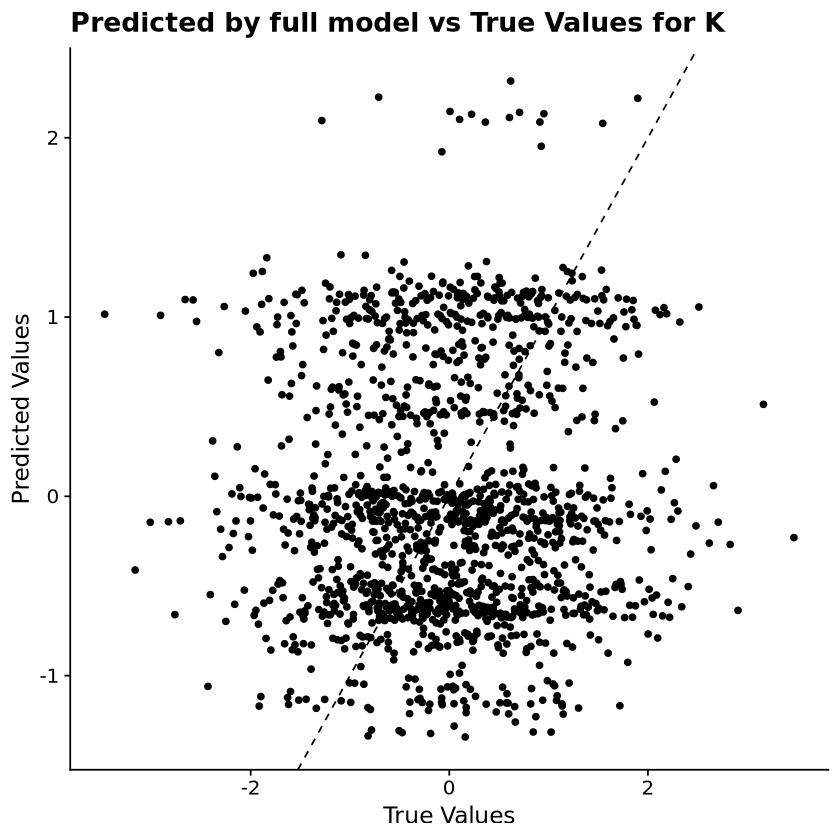

In [56]:
prediction_plot <- ggplot() +
  geom_point(data = predictions_full, aes(x = train$K, y = K)) + 
  geom_abline(slope = 1, intercept = 0, linetype = "dashed", color = "black") +
  labs(x = "True Values", y = "Predicted Values", color = "Model") +
  scale_color_viridis_d() +
  theme_cowplot() +
  ggtitle("Predicted by full model vs True Values for K")
prediction_plot

In [62]:
ggsave("../plots/predicting_K_drb113_p109.png", prediction_plot)

Saving 6.67 x 6.67 in image



Saving 6.67 x 6.67 in image



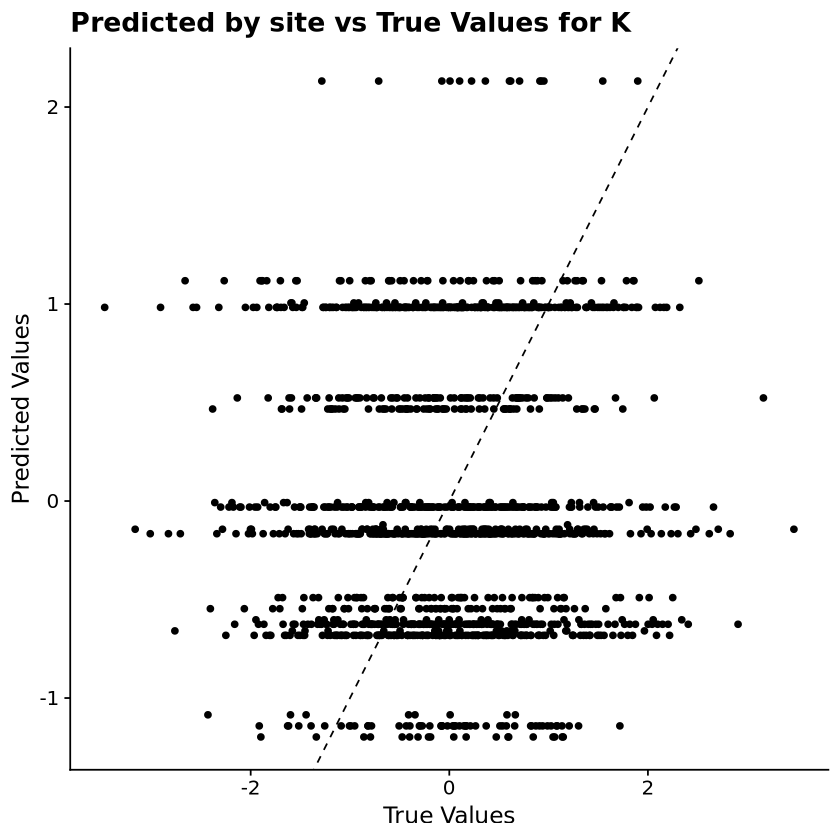

In [92]:
prediction_site <- ggplot() +
  geom_point(data = predictions_site, aes(x = train$K, y = K)) + 
  geom_abline(slope = 1, intercept = 0, linetype = "dashed", color = "black") +
  labs(x = "True Values", y = "Predicted Values", color = "Model") +
  scale_color_viridis_d() +
  theme_cowplot() +
  ggtitle("Predicted by site vs True Values for K")
prediction_plot
ggsave("../plots/predicting_site_K_drb113_p109.png", prediction_site)

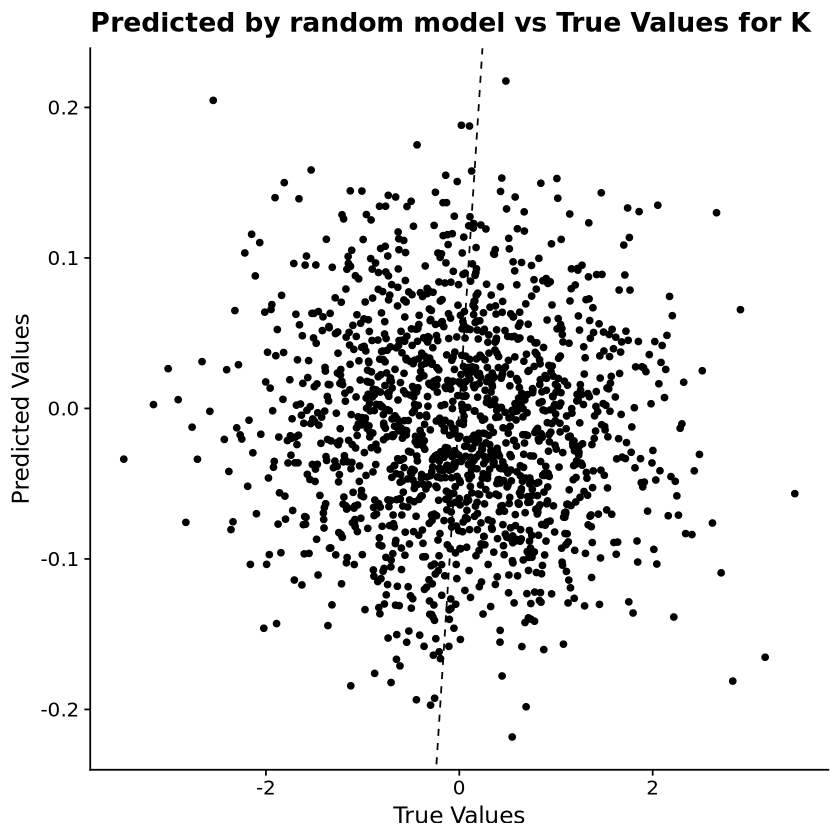

In [54]:
prediction_random_plot <- ggplot() +
  geom_point(data = predictions_null_random, aes(x = train$K, y = K)) + 
  geom_abline(slope = 1, intercept = 0, linetype = "dashed", color = "black") +
  labs(x = "True Values", y = "Predicted Values", color = "Model") +
  scale_color_viridis_d() +
  theme_cowplot() +
  ggtitle("Predicted by random model vs True Values for K")
prediction_random_plot

In [58]:
ggsave("../plots/predicting_random_K_drb113_p109.png", prediction_random_plot, width = 7)

Saving 7 x 6.67 in image



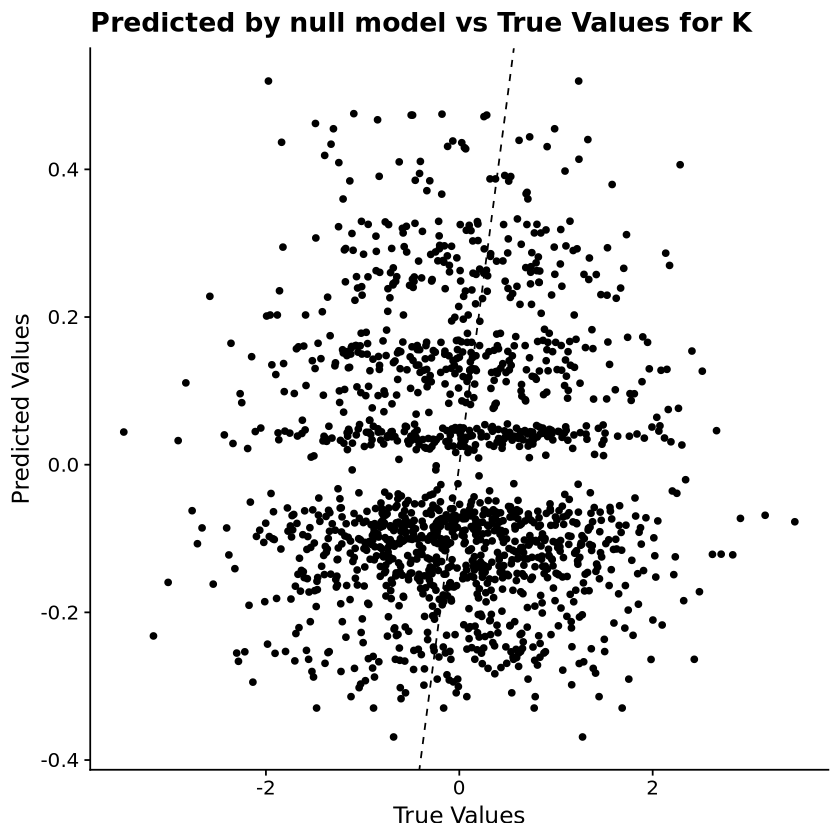

In [68]:
prediction_null_plot <- ggplot() +
  geom_point(data = predictions_null, aes(x = train$K, y = K)) + 
  geom_abline(slope = 1, intercept = 0, linetype = "dashed", color = "black") +
  labs(x = "True Values", y = "Predicted Values", color = "Model") +
  scale_color_viridis_c() +
  theme_cowplot() +
  ggtitle("Predicted by null model vs True Values for K")
prediction_null_plot

In [61]:
ggsave("../plots/predicting_null_K_drb113_p109.png", prediction_null_plot, width = 7)

Saving 7 x 6.67 in image



In [64]:
mse_results_all_tests <- fread('../PCA_experiment/mse_results_all_tests_irt_freq_unique.csv')

In [67]:
head(mse_results_all_tests)

AA mse_full  mse_full_random mse_null  mse_null_random mse_site  test_name
1 A  0.9250348 0.9268325       0.9941079 0.9947297       0.9276118 1_0.3    
2 C  1.0007643 1.0026589       1.0032274 1.0044777       0.9990394 1_0.3    
3 D  0.9437427 0.9431900       1.0291767 1.0182543       0.9435394 1_0.3    
4 E  0.7671389 0.7677192       0.9793452 0.9802995       0.7662937 1_0.3    
5 F  0.8805988 0.8836770       0.9247719 0.9304978       0.8828442 1_0.3    
6 G  0.8423855 0.8396657       0.8739917 0.8701040       0.8396343 1_0.3

In [65]:
mse_full_and_random <- ggplot(mse_results_all_tests, aes(x = mse_full, y = mse_null_random, color = )) +
    geom_point() + 
    theme_cowplot() + 
    facet_wrap(~AA, scales = 'free')

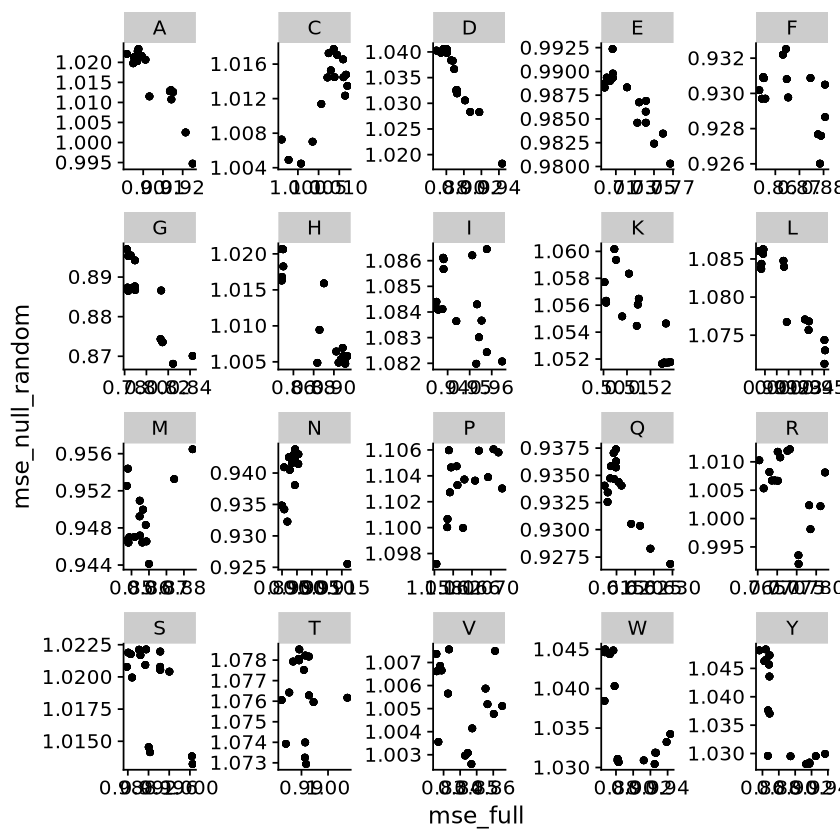

In [66]:
mse_full_and_random

In [131]:
mse_results_all_tests %>% filter(AA == 'C')

AA mse_full mse_full_random mse_null mse_null_random mse_site  test_name
1   C  1.000764 1.002659        1.003227 1.004478        0.9990394 1_0.3    
2   C  1.000764 1.002659        1.003227 1.004478        0.9990394 1_0.4    
3   C  1.000764 1.002659        1.003227 1.004478        0.9990394 1_0.5    
4   C  1.000764 1.002659        1.003227 1.004478        0.9990394 1_0.6    
5   C  1.000764 1.002659        1.003227 1.004478        0.9990394 1_0.7    
6   C  1.000764 1.002659        1.003227 1.004478        0.9990394 1_0.8    
7   C  1.000764 1.002659        1.003227 1.004478        0.9990394 1_0.9    
8   C  1.000764 1.002659        1.003227 1.004478        0.9990394 1_1      
9   C  1.009467 1.015140        1.015771 1.017071        0.9990394 10_0.3   
10  C  1.009467 1.015140        1.015771 1.017071        0.9990394 10_0.4   
11  C  1.009467 1.015140        1.015771 1.017071        0.9990394 10_0.5   
12  C  1.009467 1.015140        1.015771 1.017071        0.9990394 10_0.6   
13  C  1.009467 1.015140        1.015771 1.017071        0.9990394 10_0.7   
14  C  1.009467 1.015140        1.015771 1.017071        0.9990394 10_0.8   
15  C  1.009467 1.015140        1.015771 1.017071        0.9990394 10_0.9   
16  C  1.009467 1.015140        1.015771 1.017071        0.9990394 10_1     
17  C  1.008842 1.012891        1.016144 1.014491        0.9990394 11_0.3   
18  C  1.008842 1.012891        1.016144 1.014491        0.9990394 11_0.4   
19  C  1.008842 1.012891        1.016144 1.014491        0.9990394 11_0.5   
20  C  1.008842 1.012891        1.016144 1.014491        0.9990394 11_0.6   
21  C  1.008842 1.012891        1.016144 1.014491        0.9990394 11_0.7   
22  C  1.008842 1.012891        1.016144 1.014491        0.9990394 11_0.8   
23  C  1.008842 1.012891        1.016144 1.014491        0.9990394 11_0.9   
24  C  1.008842 1.012891        1.016144 1.014491        0.9990394 11_1     
25  C  1.010940 1.014851        1.018945 1.016546        0.9990394 12_0.3   
26  C  1.010940 1.014851        1.018945 1.016546        0.9990394 12_0.4   
27  C  1.010940 1.014851        1.018945 1.016546        0.9990394 12_0.5   
28  C  1.010940 1.014851        1.018945 1.016546        0.9990394 12_0.6   
29  C  1.010940 1.014851        1.018945 1.016546        0.9990394 12_0.7   
30  C  1.010940 1.014851        1.018945 1.016546        0.9990394 12_0.8   
⋮   ⋮  ⋮        ⋮               ⋮        ⋮               ⋮         ⋮        
99  C  1.007148 1.011869        1.014730 1.014449        0.9990394 6_0.5    
100 C  1.007148 1.011869        1.014730 1.014449        0.9990394 6_0.6    
101 C  1.007148 1.011869        1.014730 1.014449        0.9990394 6_0.7    
102 C  1.007148 1.011869        1.014730 1.014449        0.9990394 6_0.8    
103 C  1.007148 1.011869        1.014730 1.014449        0.9990394 6_0.9    
104 C  1.007148 1.011869        1.014730 1.014449        0.9990394 6_1      
105 C  1.007953 1.012720        1.014880 1.015280        0.9990394 7_0.3    
106 C  1.007953 1.012720        1.014880 1.015280        0.9990394 7_0.4    
107 C  1.007953 1.012720        1.014880 1.015280        0.9990394 7_0.5    
108 C  1.007953 1.012720        1.014880 1.015280        0.9990394 7_0.6    
109 C  1.007953 1.012720        1.014880 1.015280        0.9990394 7_0.7    
110 C  1.007953 1.012720        1.014880 1.015280        0.9990394 7_0.8    
111 C  1.007953 1.012720        1.014880 1.015280        0.9990394 7_0.9    
112 C  1.007953 1.012720        1.014880 1.015280        0.9990394 7_1      
113 C  1.008656 1.015706        1.015068 1.017749        0.9990394 8_0.3    
114 C  1.008656 1.015706        1.015068 1.017749        0.9990394 8_0.4    
115 C  1.008656 1.015706        1.015068 1.017749        0.9990394 8_0.5    
116 C  1.008656 1.015706        1.015068 1.017749        0.9990394 8_0.6    
117 C  1.008656 1.015706        1.015068 1.017749        0.9990394 8_0.7    
118 C  1.008656 1.015706        1.015068 1.017749        0.9990394 8_0.8    
